## Process Optimization - the `Main` code 

### First Batch of Bayesian Optimization based on Experimental Data produced on Sep 22, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [2]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

### Load the experimental data

In [3]:
df_film = pd.read_excel('./ML Perov Data/ML perov data stanford.xlsx', sheet_name='2020_09_22_film')
print(df_film.columns)
df_film.iloc[:,:-1]

Index(['ML Condition', 'Temp [degC]', 'speed [mm/s]', 'sprayFL [uL/min]',
       'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]', '  Success or Fail',
       'Unnamed: 8'],
      dtype='object')


ML Condition  Temp [degC]  speed [mm/s]  sprayFL [uL/min]  plamsaH [cm]  \
0              0          155           200              5000           1.2   
1              1          160           225              3000           0.8   
2              2          135           200              2500           1.0   
3              3          150           175              2000           1.0   
4              4          170           275              4500           1.2   
5              5          175           250              3500           1.2   
6              6          140           150              4000           1.0   
7              7          155           225              4000           0.8   
8              8          130           175              3500           0.8   
9              9          135           125              2500           1.2   
10            10          130           250              4500           1.2   
11            11          145           125              3500           1.0   
12            12          145           150              4500           1.0   
13            13          160           275              3500           0.8   
14            14          165           225              4000           1.0   
15            15          125           275              3000           0.8   
16            16          170           175              5000           1.0   
17            17          150           100              2500           1.0   
18            18          140           300              2000           1.0   
19            19          165           125              3000           1.0   

    gasFL [L/min]  plasmaDC [%]    Success or Fail  
0              35            50                  1  
1              30            75                  0  
2              25            75                  1  
3              20           100                  0  
4              16            50                  0  
5              25            75                  0  
6              20            75                  1  
7              30            25                  0  
8              25            75                  1  
9              20            25                  1  
10             30            50                  1  
11             25            50                  1  
12             16           100                  1  
13             20           100                  0  
14             25            25                  1  
15             20            50                  1  
16             16            75                  0  
17             35            50                  1  
18             30            50                  0  
19             30            75                  0

In [4]:
df_device = pd.read_excel('./ML Perov Data/ML perov data stanford.xlsx', sheet_name='2020_09_22_device')
print(df_device.columns)
df_device.columns = ['ML Condition', 'Sample', 'Temp [degC]', 'speed [mm/s]',
       'sprayFL [uL/min]', 'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]',
       'Isc [mA]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_device


Index(['ML Condition', 'Sample', 'Temp [degC]', 'speed [mm/s]',
       'sprayFL [uL/min]', 'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]',
       'Isc', 'Jsc', 'Voc', 'FF', 'PCE'],
      dtype='object')


ML Condition                               Sample  Temp [degC]  \
0              6                       B9R_14-FR0.dat          140   
1              6                        B9L_4-FR0.dat          140   
2              6                       B10L_7-FR0.dat          140   
3              6                B10R_AFTERUP2-FR0.dat          140   
4             15              B11L_YELLOWISH2-FR0.dat          125   
5             15              B11R_YELLOWISH2-FR0.dat          125   
6             15                         B12L-FR0.dat          125   
7             15                   B12RPALE_2-FR0.dat          125   
8             10                       B13R_5-FR0.dat          130   
9             10              B14L_YELLOWISH4-FR0.dat          130   
10            10             B14R_YELLOWISH10-FR0.dat          130   
11             8                         B15L-FR0.dat          130   
12             8                 B15R_AFTERUP-FR0.dat          130   
13             8                 B16R_AFTERUP-FR0.dat          130   
14             8                       B16L_5-FR0.dat          130   
15             2                   B17LPALE_4-FR0.dat          135   
16             2                   B18RPALE_4-FR0.dat          135   
17             2                   B18LPALE_2-FR0.dat          135   
18             9          B20RGAPPY_AFTER2UP2-FR0.dat          135   
19             9                  B20LGAPPY_6-FR0.dat          135   
20             9            B21LGAPPY_AFTERUP-FR0.dat          135   
21             9           B21RGAPPY_AFTERUP3-FR0.dat          135   
22            11                       B22L_4-FR0.dat          145   
23            11  B22R_AGAIN_5MINSOAKAFTERUP3-FR0.dat          145   
24            11                 B23L_AFTERUP-FR0.dat          145   
25            11               B23R_AFTER2UP2-FR0.dat          145   
26            12                       B24L_3-FR0.dat          145   
27            12                       B24R_8-FR0.dat          145   
28            12                         B25L-FR0.dat          145   
29            12                       B25R_7-FR0.dat          145   
30            17                         B28R-FR0.dat          150   
31            17                       B28L_2-FR0.dat          150   
32             0                         B29L-FR0.dat          155   
33             0                       B29R_3-FR0.dat          155   
34             7                         B30L-FR0.dat          155   
35             7                         B30R-FR0.dat          155   
36            14                   B36LPALE_3-FR0.dat          165   
37            14                   B36RPALE_8-FR0.dat          165   

    speed [mm/s]  sprayFL [uL/min]  plamsaH [cm]  gasFL [L/min]  plasmaDC [%]  \
0            150              4000           1.0             20            75   
1            150              4000           1.0             20            75   
2            150              4000           1.0             20            75   
3            150              4000           1.0             20            75   
4            275              3000           0.8             20            50   
5            275              3000           0.8             20            50   
6            275              3000           0.8             20            50   
7            275              3000           0.8             20            50   
8            250              4500           1.2             30            50   
9            250              4500           1.2             30            50   
10           250              4500           1.2             30            50   
11           175              3500           0.8             25            75   
12           175              3500           0.8             25            75   
13           175              3500           0.8             25            75   
14           175              3500           0.8          

In [5]:
df_previous  = pd.read_excel("./ML Perov Data/new_plamsa_previous_selected_20200927.xlsx", sheet_name= "Sheet1")
print(df_previous.columns)
df_previous = df_previous.iloc[:,1:]
df_previous

Index(['Unnamed: 0', 'Temp [degC]', 'speed [mm/s]', 'sprayFL [uL/min]',
       'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]', 'Jsc [mA/cm2]',
       'Voc [V]', 'FF [-]', 'Efficiency [%]'],
      dtype='object')


Temp [degC]  speed [mm/s]  sprayFL [uL/min]  plamsaH [cm]  gasFL [L/min]  \
0           145           150              3000           1.0             15   
1           145           150              3000           1.0             15   
2           145           150              3000           1.0             15   
3           145           150              3000           1.0             15   
4           145           150              3000           1.0             15   
..          ...           ...               ...           ...            ...   
61          145           100              3000           1.0             15   
62          140           150              4500           1.0             15   
63          140           150              4500           1.0             15   
64          140           150              4000           0.8             15   
65          140           150              4000           0.8             15   

    plasmaDC [%]  Jsc [mA/cm2]    Voc [V]    FF [-]  Efficiency [%]  
0            100      0.946349  22.270719  0.736124         15.5145  
1            100      0.918172  21.633918  0.764603         15.1878  
2            100      0.919626  21.668702  0.763088         15.2061  
3            100      0.942140  20.526225  0.740573         14.3216  
4            100      0.952371  20.491409  0.740810         14.4572  
..           ...           ...        ...       ...             ...  
61           100      0.839688  18.364500  0.546522          8.4276  
62           100      0.983829  21.500242  0.523180         11.0666  
63           100      0.968943  20.237956  0.555148         10.8861  
64           100      0.960732  20.521194  0.661844         13.0485  
65           100      0.936220  19.452934  0.654643         11.9225  

[66 rows x 10 columns]

### Set the variable space of process conditions

In [6]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temp [degC]', 
            'speed [mm/s]', 
            'sprayFL [uL/min]',  
            'plamsaH [cm]', 
            'gasFL [L/min]',
            'plasmaDC [%]']

def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [7]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1),
                                 ContinuousParameter('x2', 0, 1),
                                 ContinuousParameter('x3', 0, 1),
                                 ContinuousParameter('x4', 0, 1),
                                 ContinuousParameter('x5', 0, 1),
                                 ContinuousParameter('x6', 0, 1)
                                 ])

### Define the Probabilistic Constrained Bayesian Optimization Loop
- This Optimization loop takes in two contraint functions (one for binary film quality; one for previous device data)
- The data for constraint function is converted into a probablistic constraint (with a scaling factor spec the contraint strength on the acquisition function)

In [8]:
from typing import Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

class ProbabilisticConstraintBayesianOptimizationLoop2(OuterLoop):
    def __init__(self, space: ParameterSpace, model_objective: Union[IModel, IDifferentiable],
                 model_constraint1: Union[IModel, IDifferentiable], 
                 model_constraint2: Union[IModel, IDifferentiable],
                 acquisition: Acquisition = None,
                 update_interval: int = 1, batch_size: int = 1):

        """
        Emukit class that implements a loop for building Bayesian optimization with an unknown constraint.
        For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param space: Input space where the optimization is carried out.
        :param model_objective: The model that approximates the underlying objective function
        :param model_constraint: The model that approximates the unknown constraints
        :param acquisition: The acquisition function for the objective function (default, EI).
        :param update_interval:  Number of iterations between optimization of model hyper-parameters. Defaults to 1.
        :param batch_size: How many points to evaluate in one iteration of the optimization loop. Defaults to 1.
        """

#         if not np.all(np.isclose(model_objective.X, model_constraint.X)):
#             raise ValueError('Emukit currently only supports identical '
#                              'training inputs for the constrained and objective model')
        self.model_objective = model_objective
        self.model_constraint1 = model_constraint1
        self.model_constraint2 = model_constraint2
        
        if acquisition is None:
            acquisition = ExpectedImprovement(model_objective)
        
        acquisition_constraint1 = ScaledProbabilityOfFeasibility(model_constraint1, max_value = 1, min_value = 0.2)
        acquisition_constraint2 = ScaledProbabilityOfFeasibility(model_constraint2, max_value = 1, min_value = 0.8)
        acquisition_constraint = acquisition_constraint1*acquisition_constraint2
        acquisition_constrained = acquisition * acquisition_constraint

        model_updater_objective = FixedIntervalUpdater(model_objective, update_interval)
        model_updater_constraint1 = FixedIntervalUpdater(model_constraint1, update_interval,
                                                        lambda state: state.Y_constraint1)
        model_updater_constraint2 = FixedIntervalUpdater(model_constraint2, update_interval,
                                                        lambda state: state.Y_constraint2)

        acquisition_optimizer = GradientAcquisitionOptimizer(space)
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition_constrained, acquisition_optimizer)
        else:
            log_acquisition = LogAcquisition(acquisition_constrained)
            candidate_point_calculator = LocalPenalizationPointCalculator(log_acquisition, acquisition_optimizer,
                                                                          model_objective, space, batch_size)
        loop_state = create_loop_state(model_objective.X, model_objective.Y)
        
        #loop_state = create_loop_state(model_objective.X, model_objective.Y, Y_constraint=model_constraint.Y)

        super(ProbabilisticConstraintBayesianOptimizationLoop2, self).__init__(candidate_point_calculator,
                                                                              [model_updater_objective, model_updater_constraint1,model_updater_constraint2],
                                                                              loop_state)
#     def suggest_next_locations(self):
#         return self.candidate_point_calculator.compute_next_points(self.loop_state)
    
#     def acquisition_evaluate(self, X: loop_sate.X):
#         return acquisition.evaluate(X), acquisition_constraint.evaluate(X), acquisition_constrained.evaluate(X)


In [9]:
from typing import Tuple, Union
import scipy.stats
import numpy as np
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable

class ScaledProbabilityOfFeasibility(Acquisition):

    def __init__(self, model: Union[IModel, IDifferentiable], jitter: float = float(0),
                 max_value: float = float(1), min_value: float = float(0)) -> None:
        """
        This acquisition computes for a given input point the probability of satisfying the constraint
        C<0. For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param model: The underlying model that provides the predictive mean and variance for the given test points
        :param jitter: Jitter to balance exploration / exploitation
        """
        self.model = model
        self.jitter = jitter
        self.max_value = max_value
        self.min_value = min_value

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: numpy array with the probability of satisfying the constraint at the points x.
        """
        mean, variance = self.model.predict(x)
        mean += self.jitter

        standard_deviation = np.sqrt(variance)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        return cdf*(self.max_value-self.min_value)+self.min_value

    def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
        """
        Computes the  probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: tuple of numpy arrays with the probability of satisfying the constraint at the points x 
        and its gradient.
        """
        mean, variance = self.model.predict(x)
        standard_deviation = np.sqrt(variance)

        dmean_dx, dvariance_dx = self.model.get_prediction_gradients(x)
        dstandard_devidation_dx = dvariance_dx / (2 * standard_deviation)

        mean += self.jitter
        u = - mean / standard_deviation
        pdf = scipy.stats.norm.pdf(0, mean, standard_deviation)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        dcdf_dx = - pdf * (dmean_dx + dstandard_devidation_dx * u)

        return cdf*(self.max_value-self.min_value)+self.min_value, dcdf_dx

    @property
    def has_gradients(self):
        return isinstance(self.model, IDifferentiable)

### Run GP Regression on the Experimental Data
- Experimental device data for round 0 initial sampling: device efficiency
- Experimental film data for round 0 initial sampling: binary film quality
- Previous experiment data of the "new plasma" nozzle: device efficiency

In [10]:
np.random.seed(10)

from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_init = x_normalizer(df_device.iloc[:,2:8].values)
y_init = np.transpose([df_device.iloc[:,-1].values])
xc_init = x_normalizer(df_film.iloc[:,1:-2].values)
yc_init = np.transpose([df_film.iloc[:,-2].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_normalizer(df_previous.iloc[:,0:6].values)
Yc2 = np.transpose([df_previous.iloc[:,-1].values])

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(1e-1, 1)
ker.variance.constrain_bounded(1e-1, 1000.0)
ker += GPy.kern.Bias(input_dim = input_dim)
model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)

input_dim = len(Xc[0])
ker = GPy.kern.RBF(input_dim = input_dim, ARD = True)
ker.lengthscale.constrain_bounded(1e-1, 1)#upper bound set to 1 
ker.variance.constrain_bounded(1e-1, 1000.0) 
yc_offset = 0.5 # constraint acquisition computes the probability of <0
gpy_constraint_model = GPRegression(Xc, -(Yc-yc_offset), ker) #Emukit is a minimization tool; need to make Y negative;
gpy_constraint_model.randomize()
gpy_constraint_model.optimize_restarts(num_restarts=20,verbose =False, messages=False) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

input_dim = len(Xc2[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(0.5, 1)#avoid overfitting; use a large lower bound
ker.variance.constrain_bounded(1e-1, 1000.0)
ker += GPy.kern.Bias(input_dim = input_dim)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of <0
gpy_constraint_model2 = GPRegression(Xc2 , -(Yc2-yc2_offset), ker) #Emukit is a minimization tool; need to make Y negative;
gpy_constraint_model2.randomize()
gpy_constraint_model2.optimize_restarts(num_restarts=20,verbose =False, messages=False)
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


##### Check the performance of the regression model

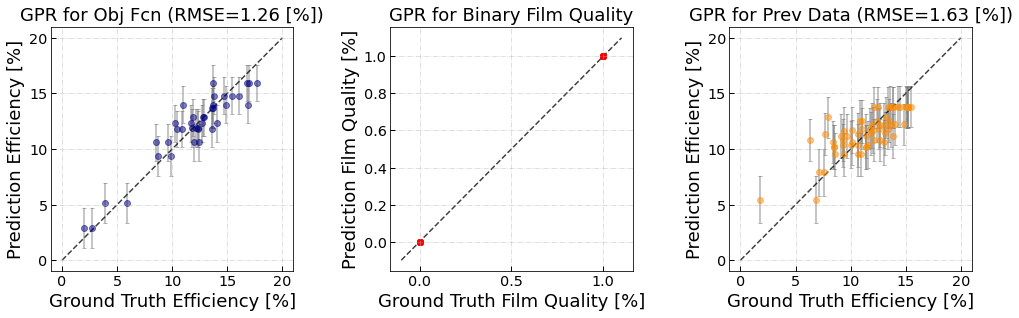

In [11]:
f_obj =  objective_model.model.predict
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

yc_pred, yc_uncer = f_cons1(Xc)
yc_pred = -yc_pred[:,-1]+yc_offset
yc_uncer = np.sqrt(yc_uncer[:,-1])

yc2_pred, yc2_uncer = f_cons2(Xc2)
yc2_pred = -yc2_pred[:,-1]+yc2_offset
yc2_uncer = np.sqrt(yc2_uncer[:,-1])


from sklearn.metrics import mean_squared_error
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 18
lims1 = (0, 20)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
title = 'GPR for Obj Fcn' + " (RMSE=%.2f" % rmse_value+' [%])'
axes[0].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[0].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)

lims2 = (-.1, 1.1)
axes[1].scatter(Yc[:,-1], yc_pred, alpha = 0.6, edgecolor = 'r', c = 'r')
axes[1].errorbar(Yc[:,-1], yc_pred, yerr = yc_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)

axes[1].plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
title = 'GPR for Binary Film Quality'
axes[1].set_xlabel('Ground Truth Film Quality [%]', fontsize = fs)
axes[1].set_ylabel('Prediction Film Quality [%]', fontsize = fs)
axes[1].set_title(title, fontsize = fs)


lims3 = (0, 17)
axes[2].scatter(Yc2[:,-1], yc2_pred, alpha = 0.5, c = 'darkorange', edgecolor = 'darkorange')
axes[2].errorbar(Yc2[:,-1], yc2_pred, yerr = yc2_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[2].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Yc2[:,-1], yc2_pred))
title = 'GPR for Prev Data' + " (RMSE=%.2f" % rmse_value+' [%])'

axes[2].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[2].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[2].set_title(title, fontsize = fs)

        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

### Start the First Run of the Batch-mode Bayesian Optimization 

In [12]:
## Expeceted Improvement (EI)
#acquisition = ExpectedImprovement(objective_model, jitter=.1)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

# # fully integreated acquisition
# acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
# #acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
# acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
# acquisition = acquisition_integrated

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 22)#batchsize>20 to account for duplication

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
X_new = x_normalizer(get_closest_array(x_denormalizer(X_new)))

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))

df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new)), columns = df_film.columns[1:7])
df_all = pd.concat([df_film.iloc[:,1:7], df_Xnew])#.sort_values(by=list(df_film.columns[1:7]))
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[20:40]
df_Xnew = df_Xnew.sort_values(by=list(df_film.columns[1:7]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df_film)
df_Xnew

total condition no.: 20
total device no.: 38
maximum Y (PCE [%]):  17.7


Temp [degC]  speed [mm/s]  sprayFL [uL/min]  plamsaH [cm]  gasFL [L/min]  \
20        130.0         200.0            4500.0           1.2           25.0   
21        135.0         125.0            3500.0           1.0           25.0   
22        135.0         150.0            2500.0           1.2           20.0   
23        135.0         150.0            3500.0           1.2           25.0   
24        135.0         175.0            4000.0           1.2           25.0   
25        135.0         175.0            4000.0           1.2           25.0   
26        140.0         100.0            3500.0           1.0           25.0   
27        140.0         100.0            3500.0           1.2           25.0   
28        140.0         100.0            4000.0           1.0           25.0   
29        140.0         125.0            2500.0           1.0           25.0   
30        140.0         125.0            3500.0           1.2           25.0   
31        140.0         150.0            3500.0           1.0           25.0   
32        140.0         150.0            4000.0           1.0           25.0   
33        145.0         100.0            3500.0           1.2           25.0   
34        145.0         100.0            4500.0           1.0           25.0   
35        145.0         125.0            3000.0           1.0           25.0   
36        145.0         150.0            3500.0           1.0           25.0   
37        145.0         150.0            4000.0           1.0           25.0   
38        150.0         125.0            3500.0           1.2           25.0   
39        150.0         150.0            4500.0           1.2           25.0   

    plasmaDC [%]  
20          50.0  
21          25.0  
22          25.0  
23          25.0  
24          25.0  
25          50.0  
26          50.0  
27          25.0  
28          50.0  
29          50.0  
30          25.0  
31          50.0  
32          50.0  
33          50.0  
34          50.0  
35          50.0  
36          50.0  
37          50.0  
38          50.0  
39          50.0

In [13]:
X_new = x_normalizer(df_Xnew.values)

y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new
y_uncer_new = np.sqrt(y_uncer_new)

acq_produc = f_cons_acq(X_new)
acq_fcn = f_raw_acq(X_new)
acq_cons = f_cons_pr(X_new)

#### Quick histogram visualization of the newly suggested process conditions

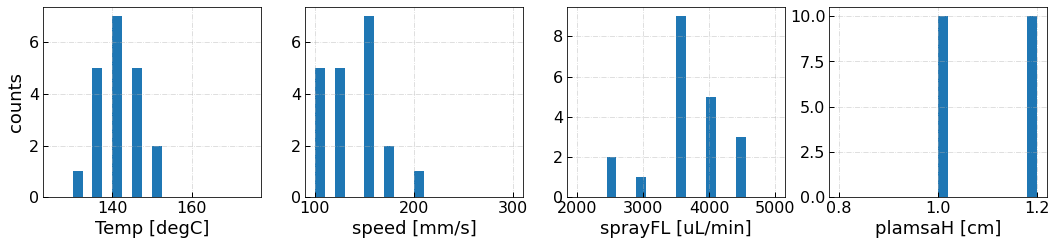

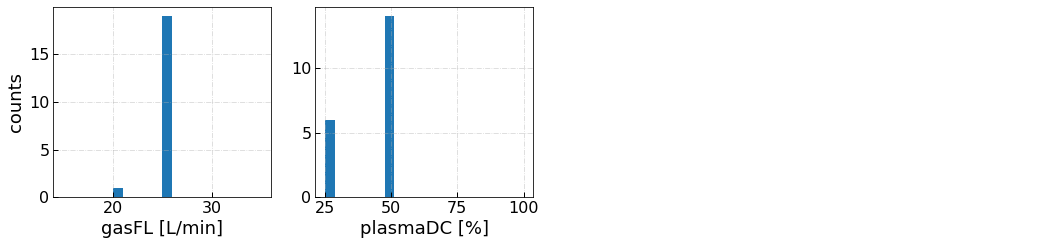

In [14]:
df = df_Xnew
df_cols = df.columns
n_col = 4 # num of columns per row in the figure

for n in np.arange(0, 8, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df.iloc[:,n], bins=20, range = (min(var_array[n]),max(var_array[n])))####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

#### Visualisation of Efficiency vs ML conditions, and Acquisition

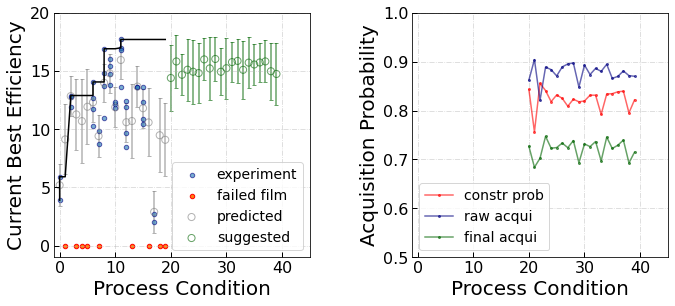

In [22]:
f_obj =  objective_model.model.predict       

device_eff = df_device.sort_values('ML Condition').iloc[:,[0,-1]].values
film_quality = df_film.sort_values('ML Condition').iloc[:,[0,-2]].values

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey = False)
fs = 20
exp_cond = np.transpose(device_eff)[0]
exp_eff = np.transpose(device_eff)[1]

axes[0].scatter(exp_cond, exp_eff, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

unsuccess_film = np.transpose(film_quality[film_quality[:,-1] ==0])
axes[0].scatter(unsuccess_film[0], unsuccess_film[1],
                #facecolor = 'none',
                edgecolor = 'red',
                s = 20, label = 'failed film')
all_cond = np.concatenate([device_eff, np.transpose(unsuccess_film)])
all_cond = all_cond[np.argsort(all_cond[:,0])]
axes[0].plot(np.transpose(all_cond)[0], np.maximum.accumulate(np.transpose(all_cond)[1]), 
         marker = 'o', ms = 0, c = 'black')

X_sorted = x_normalizer(df_film.sort_values('ML Condition').iloc[:,1:7].values)
y_pred, y_uncer = f_obj(X_sorted)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

axes[0].scatter(np.arange(len(X_sorted)), y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[0].errorbar(np.arange(len(X_sorted)), y_pred, yerr = y_uncer,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

axes[0].scatter(np.arange(len(X_new))+len(Xc), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[0].errorbar(np.arange(len(X_new))+len(Xc), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)


axes[0].set_ylabel('Current Best Efficiency', fontsize = 20)
axes[0].set_xlabel('Process Condition', fontsize = 20)

axes[0].set_ylim(-1, 20)
axes[0].set_xlim(-1, 45)
axes[0].set_xticks(np.arange(0,41,10))
axes[0].legend(fontsize = fs*0.7)

axes[1].plot(np.arange(len(X_new))+len(Xc), acq_cons, marker = 'o',
                ms = 2, alpha = 0.6, color = 'red', label = 'constr prob')
axes[1].plot(np.arange(len(X_new))+len(Xc), acq_fcn/20, marker = 'o',
                ms = 2, alpha = 0.6, color = 'navy', label = 'raw acqui')

axes[1].plot(np.arange(len(X_new))+len(Xc), acq_produc/20, marker = 'o',
                ms = 2, alpha = 0.6, color = 'darkgreen', label = 'final acqui')


axes[1].set_ylim(0.5, 1)
axes[1].set_xlim(-1, 45)
axes[1].set_xticks(np.arange(0,45,10))
axes[1].set_ylabel('Acquisition Probability', fontsize = fs)
axes[1].set_xlabel('Process Condition', fontsize = fs)

for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)
plt.legend(fontsize = fs*0.7)
plt.show()

### Visualize the Manifold of the Trained Models

##### Device Efficiency based on IV Measurement Data (after Pre-screened by Visual Inspection)
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

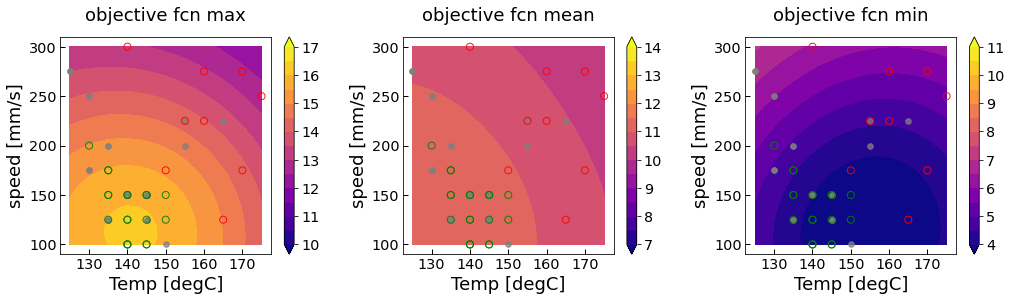

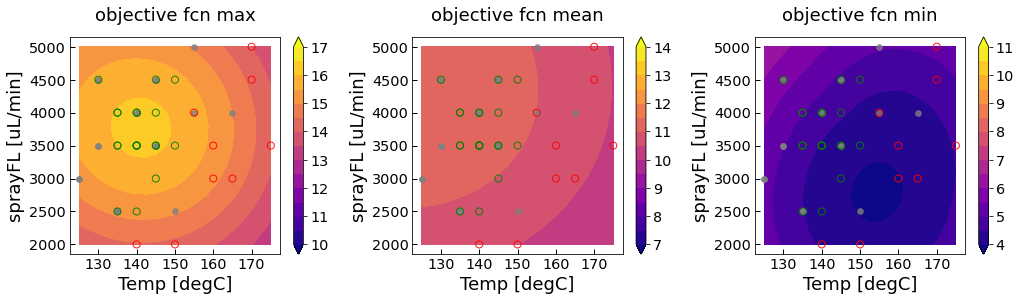

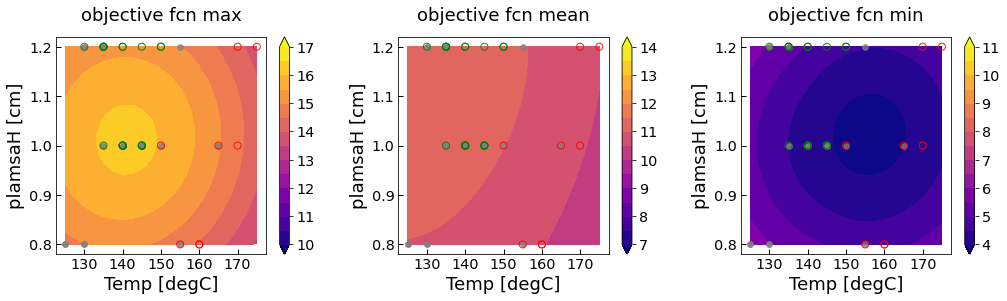

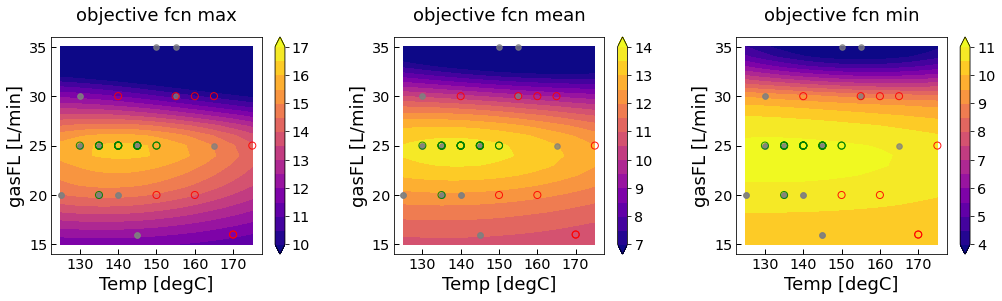

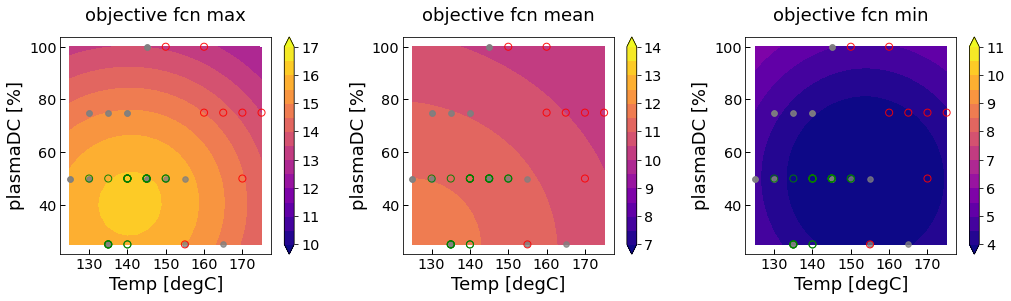

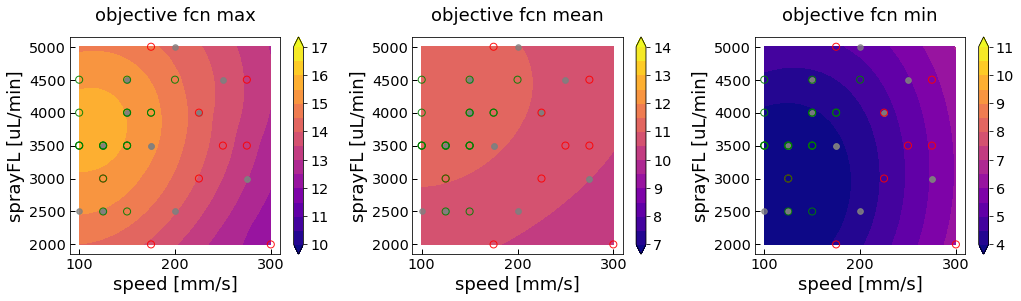

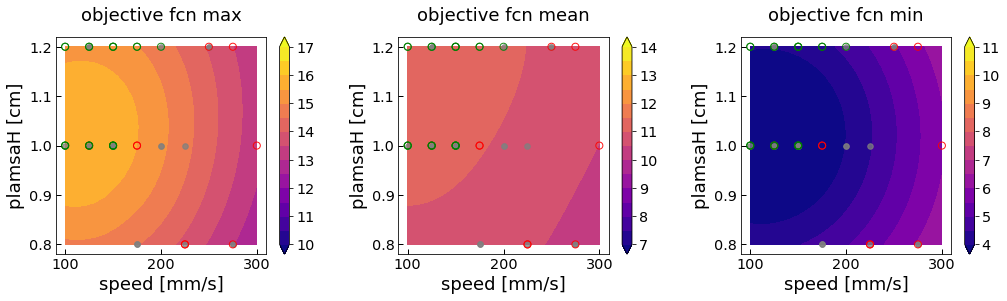

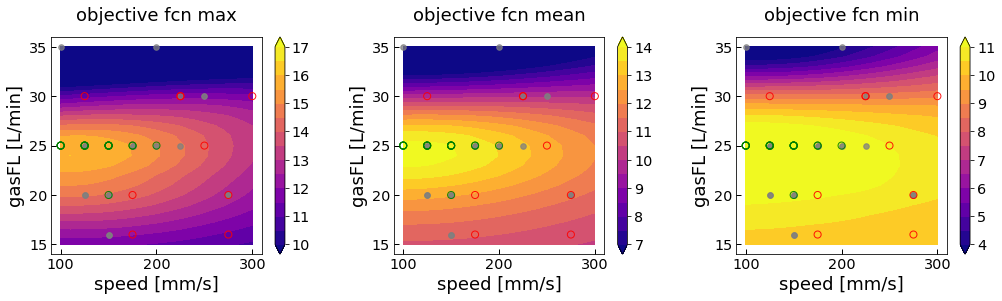

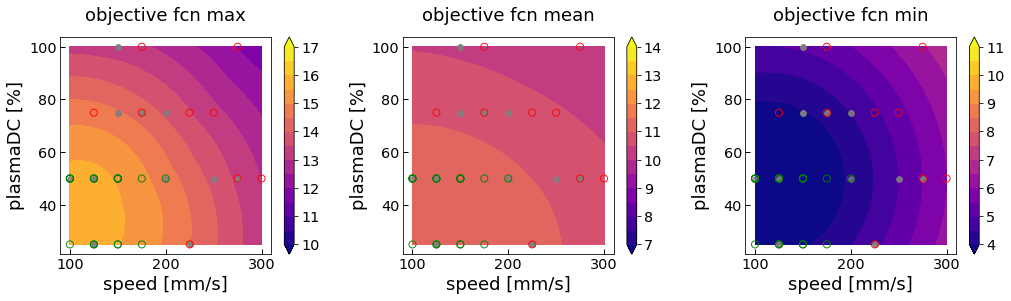

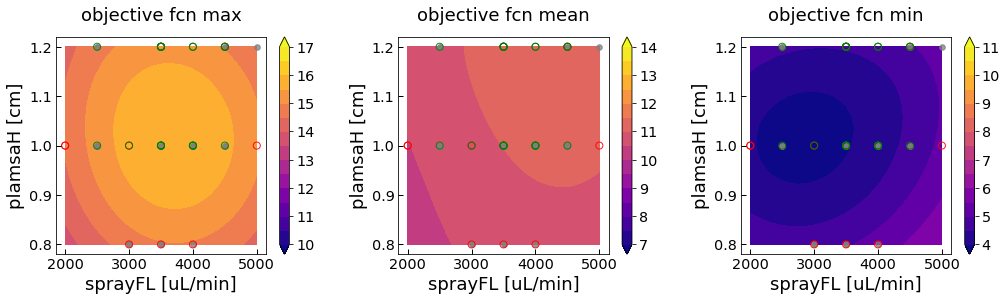

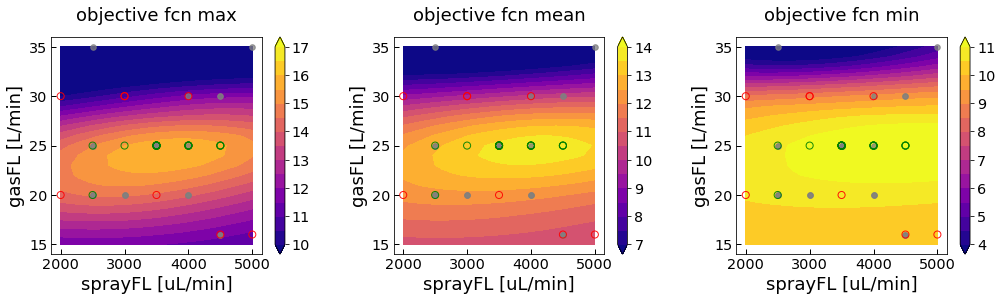

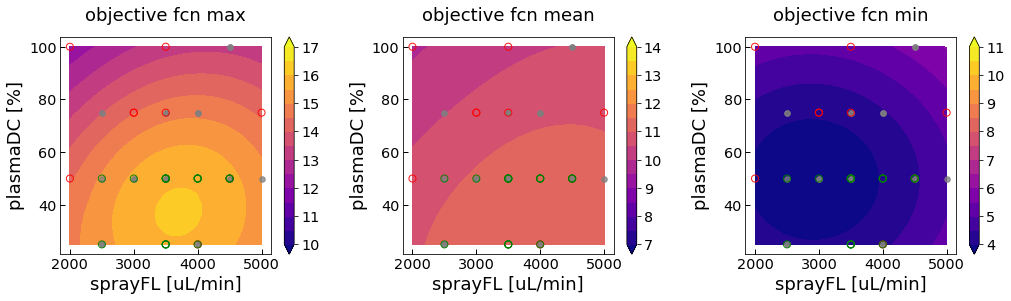

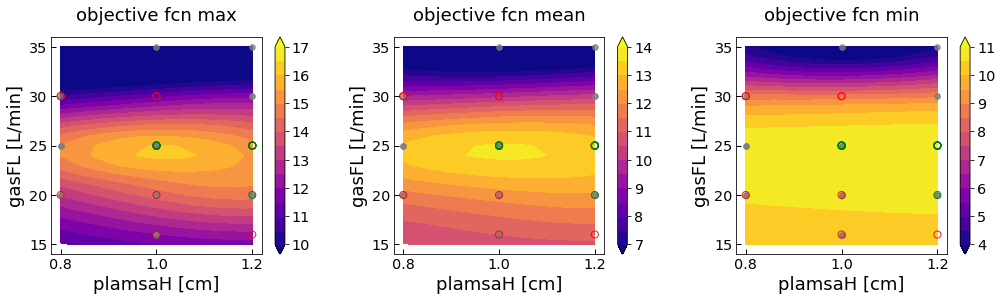

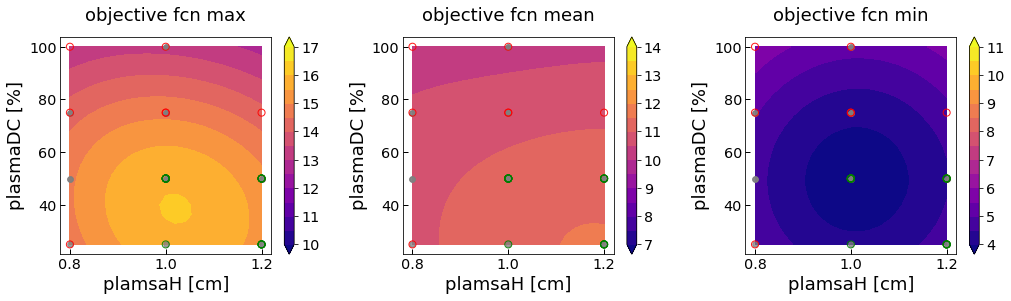

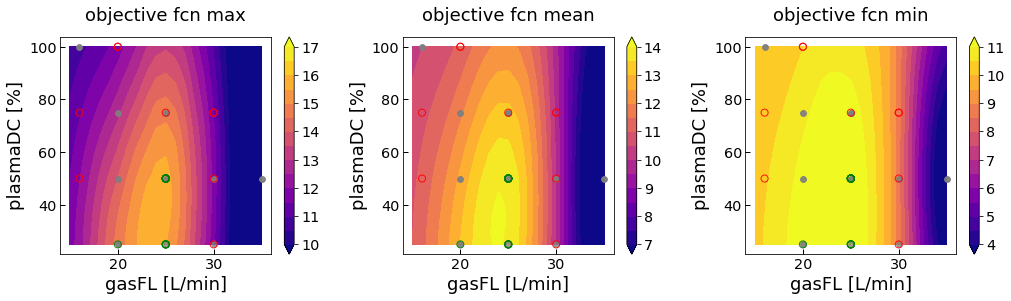

In [16]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_device.iloc[:,2:8].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [10, 7, 4]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(15)*0.5+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], ## show the conditions with poor film quality
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')

            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:
                ax.set_xticks([130, 140, 150, 160, 170])
            #ax.grid(True, linestyle='-.')

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
## Contour for Uncertainty        
#         fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         colorbar_offset = [3, 2.5, 2]
#         for ax, c_offset, y in zip(axes, colorbar_offset,
#                                    [y_uncer_max, y_uncer_mean, y_uncer_min]):
            
#             c_plt1 = ax.contourf(x1, x2, y,  levels = np.arange(11)*0.1+c_offset, cmap='plasma', extend = 'both')
#             fig.colorbar(c_plt1, ax= ax)
#             ax.scatter(x_denormalizer(X)[:, ind1], 
#                        x_denormalizer(X)[:, ind2], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'gray')
#             ax.set_xlabel(str(x_columns[ind1]))
#             ax.set_ylabel(str(x_columns[ind2]))

#             x1_delta = (np.max(x1)-np.min(x1))*0.05
#             x2_delta = (np.max(x2)-np.min(x2))*0.05
#             ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
#             ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)


#         axes[0].set_title('objective uncer max', pad = title_pad)
#         axes[1].set_title('objective uncer mean', pad = title_pad)
#         axes[2].set_title('objective uncer min', pad = title_pad)
#         plt.subplots_adjust(wspace = 0.25)
#         plt.show()

##### Constraint Probablity based Visual Inspection Data of Film Quality 
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

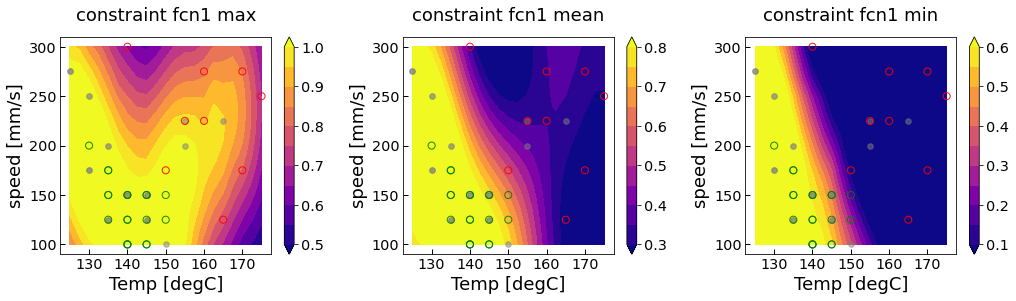

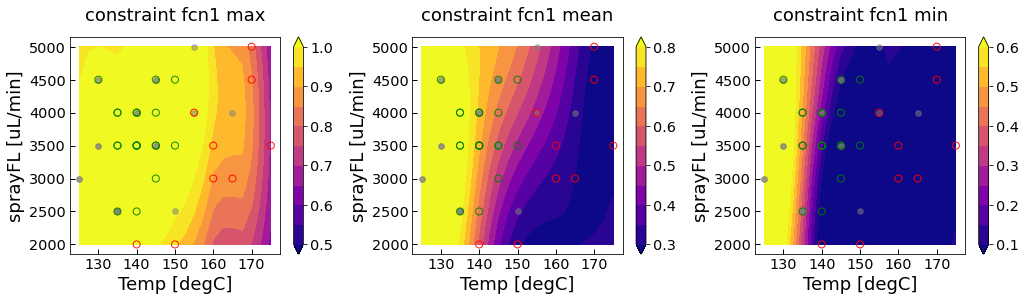

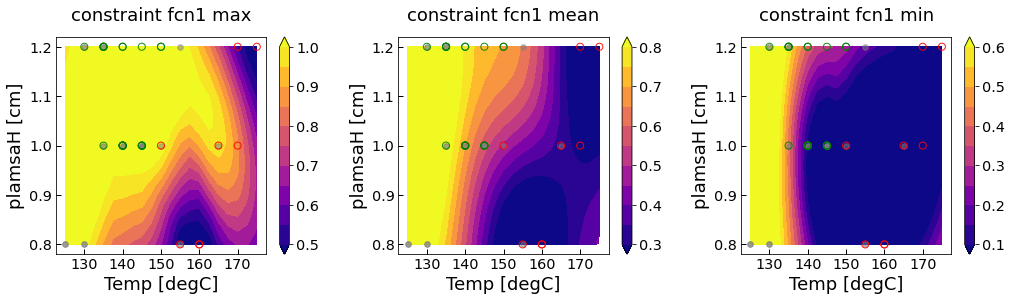

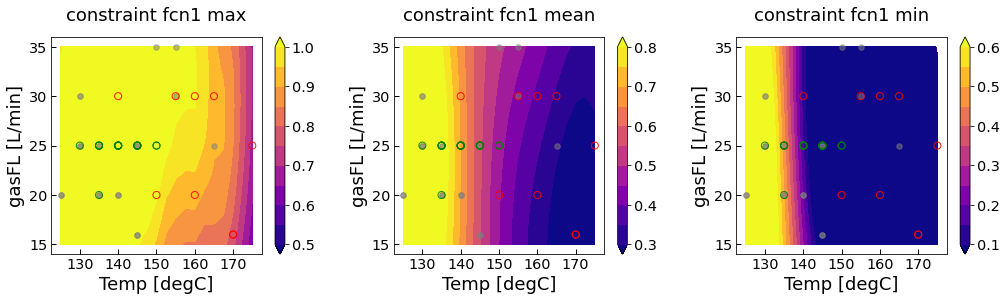

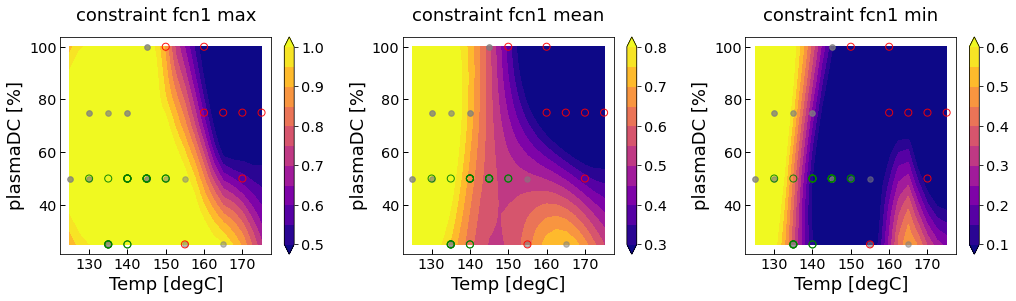

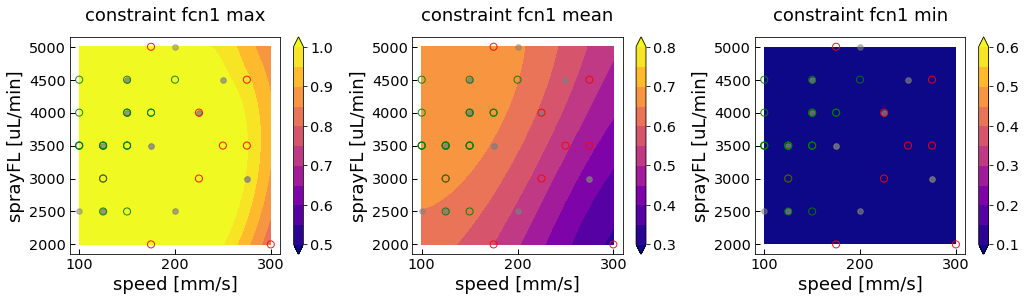

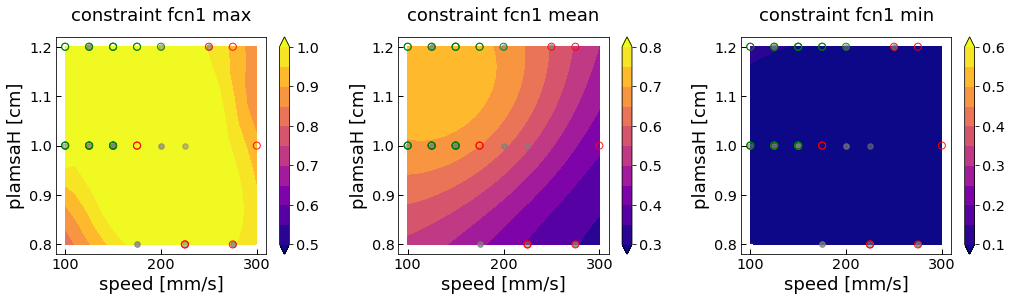

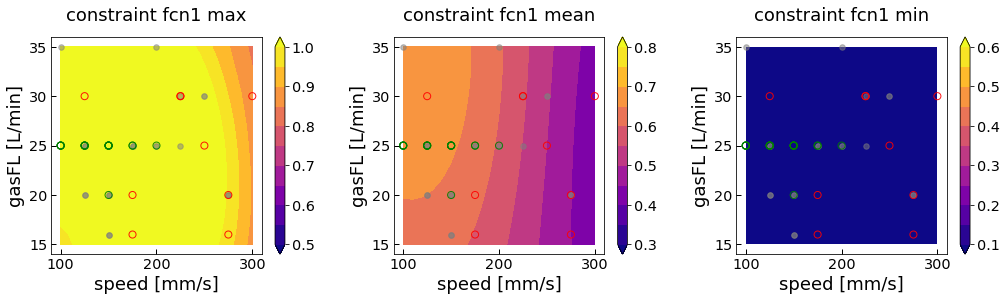

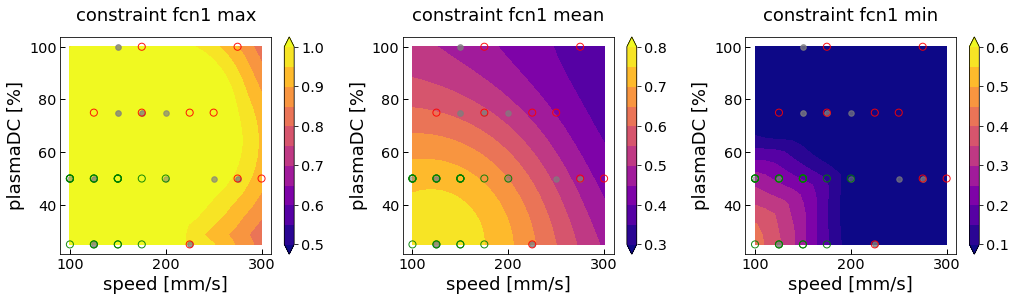

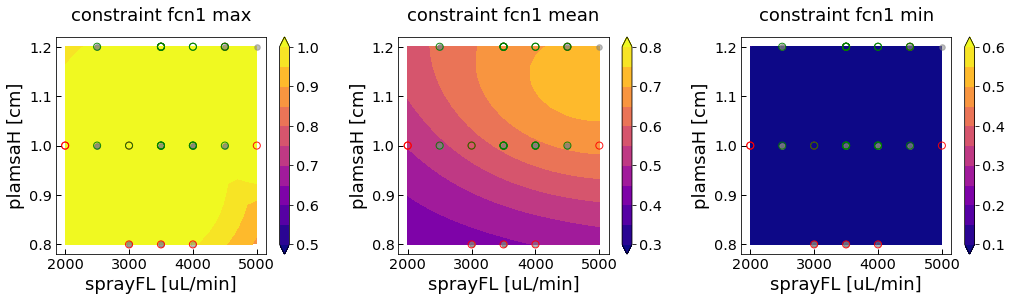

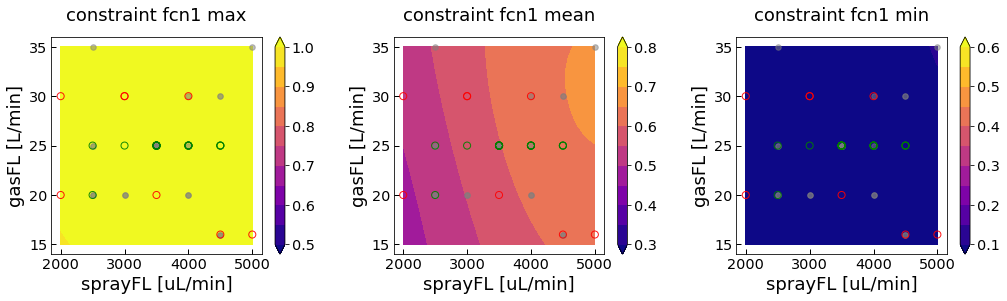

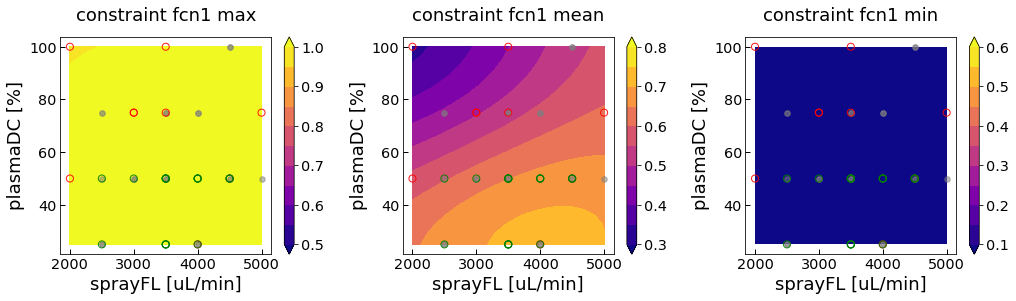

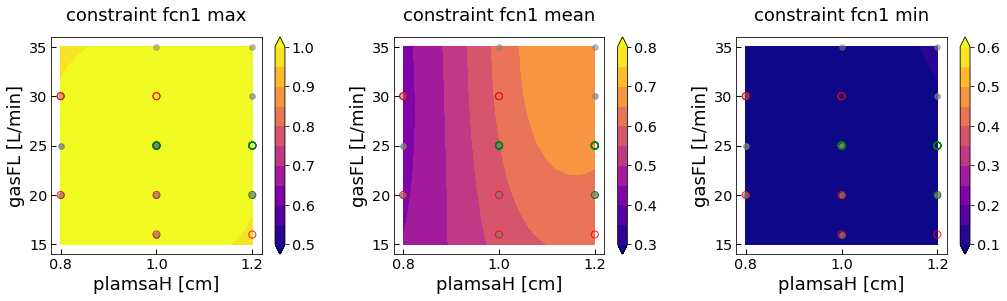

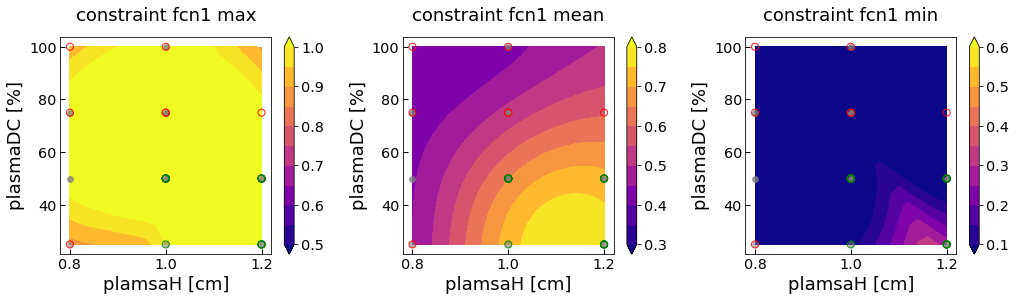

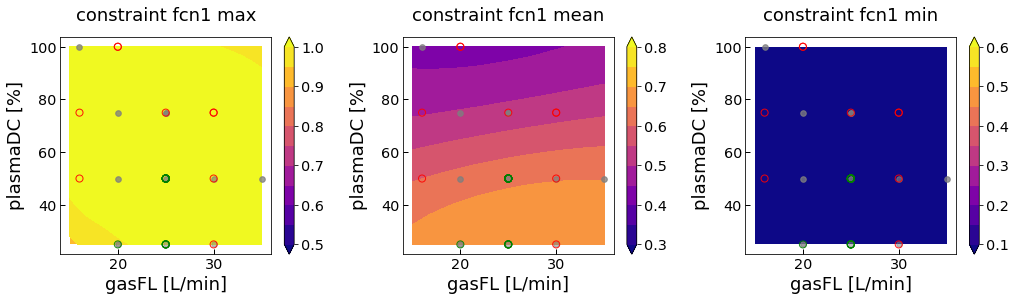

In [17]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr, yc_var = f_cons1(x_temp)
                yc_pr = -yc_pr+yc_offset
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.3, 0.1]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y, levels = np.arange(11)*0.05+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.3, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')     
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            #ax.grid(True, linestyle='-.')
            if ind1==0:
                ax.set_xticks([130, 140, 150, 160, 170])


        axes[0].set_title('constraint fcn1 max', pad = title_pad, fontsize = fs)
        axes[1].set_title('constraint fcn1 mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('constraint fcn1 min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

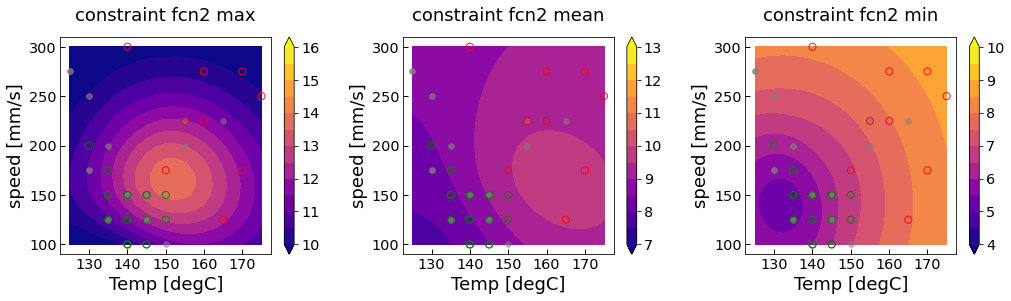

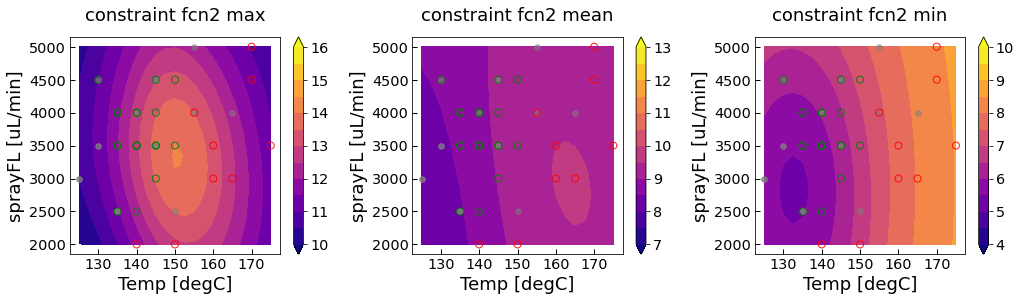

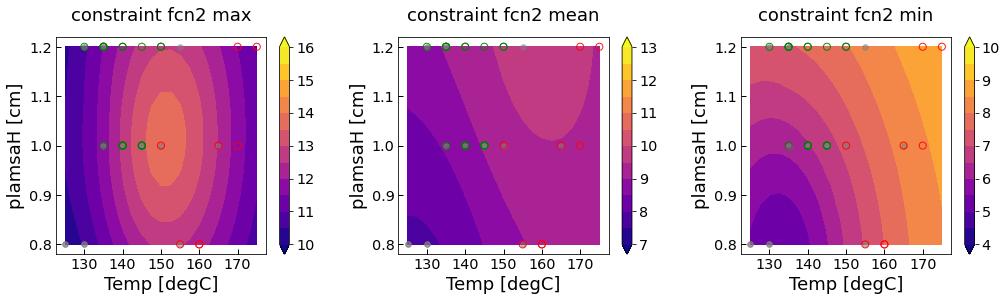

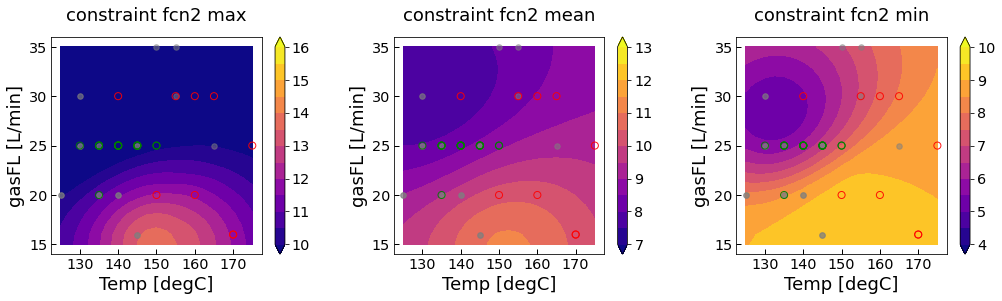

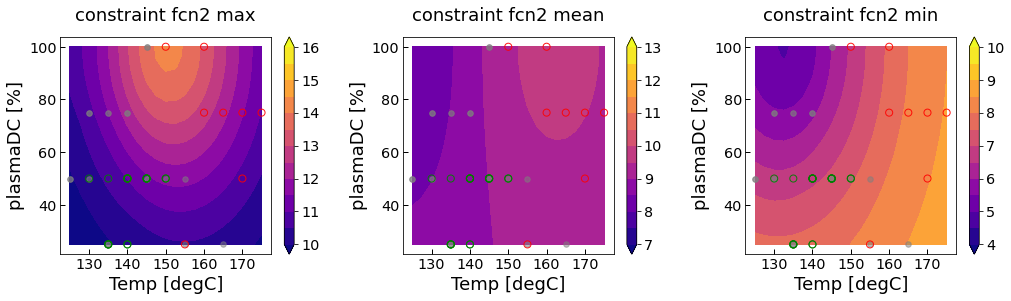

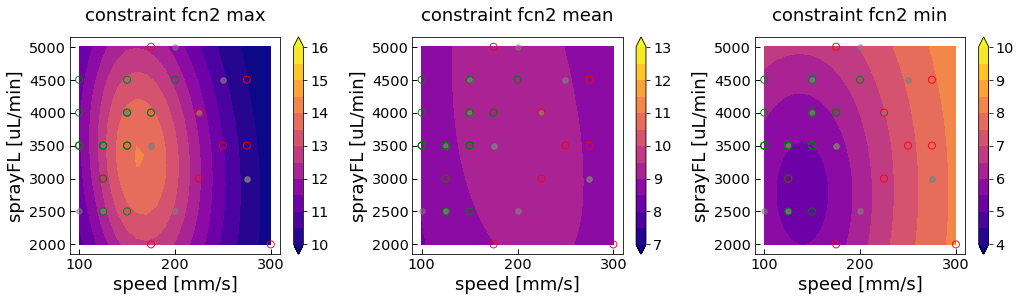

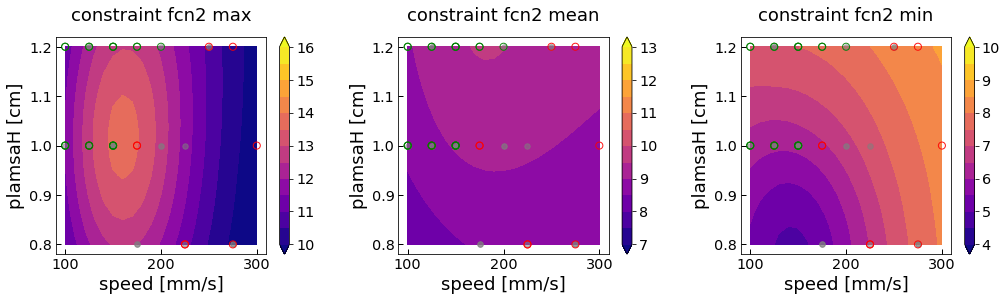

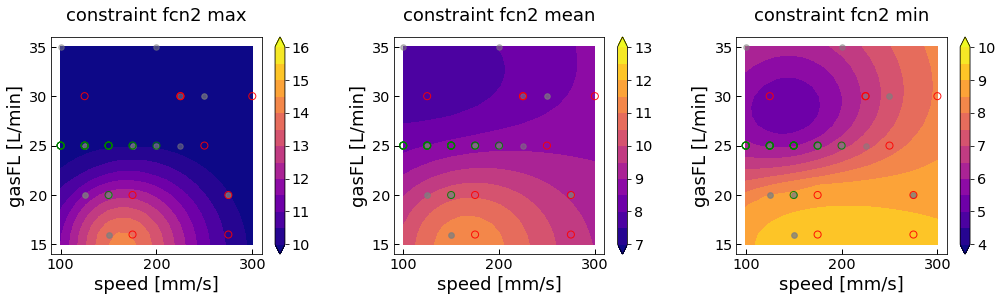

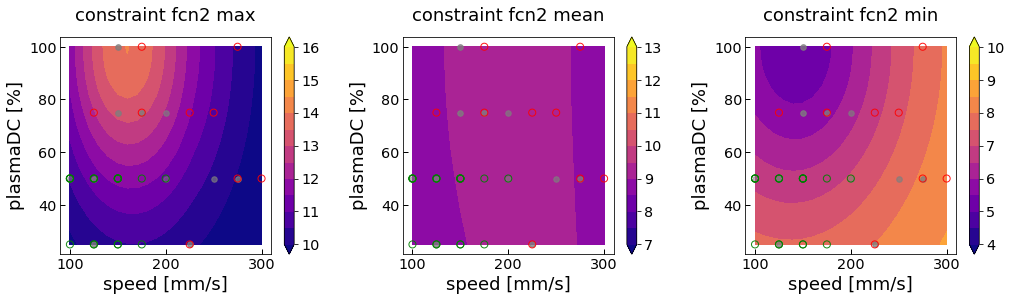

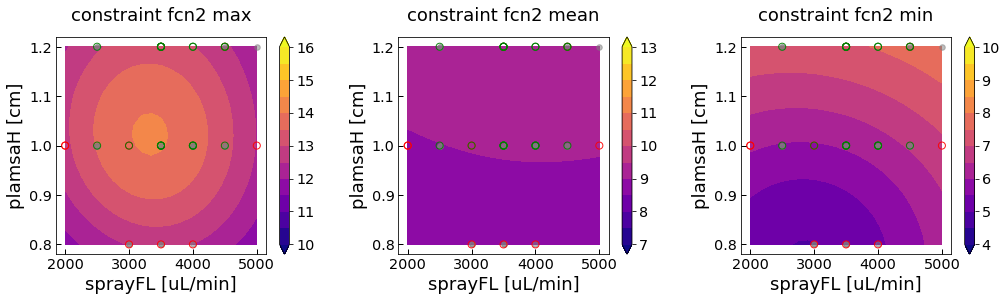

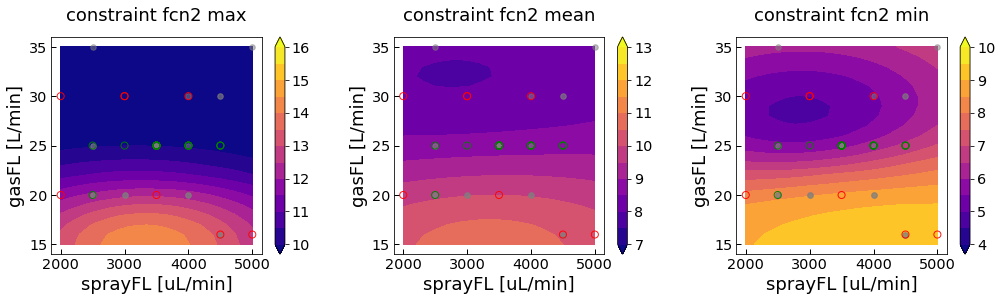

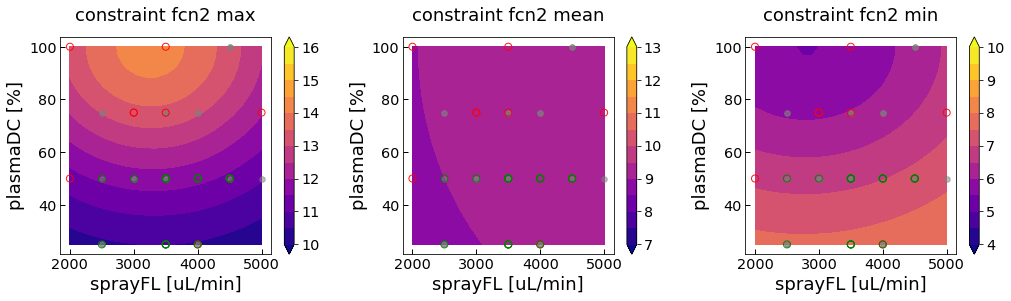

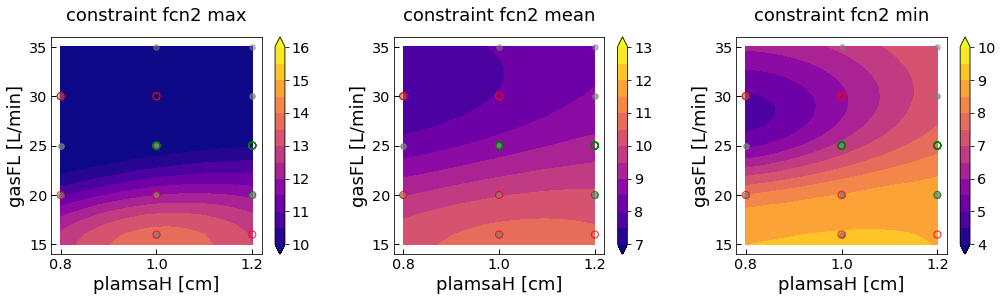

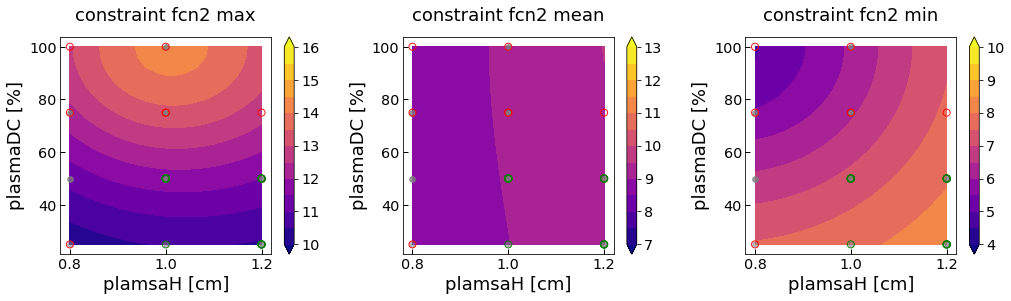

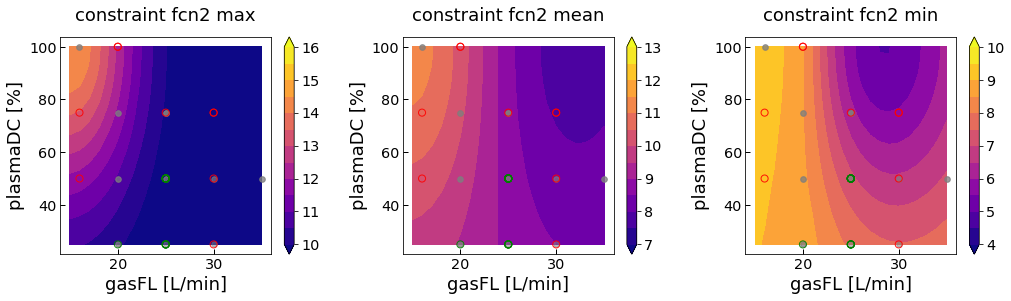

In [18]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr, yc_var = f_cons2(x_temp)
                yc_pr = -yc_pr+yc2_offset
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [10, 7, 4]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y, levels = np.arange(13)*0.5+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.3, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')     
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            #ax.grid(True, linestyle='-.')
            if ind1==0:
                ax.set_xticks([130, 140, 150, 160, 170])


        axes[0].set_title('constraint fcn2 max', pad = title_pad, fontsize = fs)
        axes[1].set_title('constraint fcn2 mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('constraint fcn2 min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

### Acquisition Functions

##### The overall constrained acquisition function

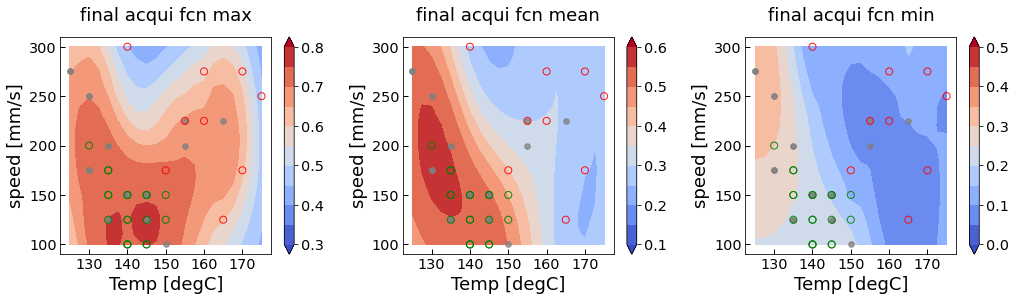

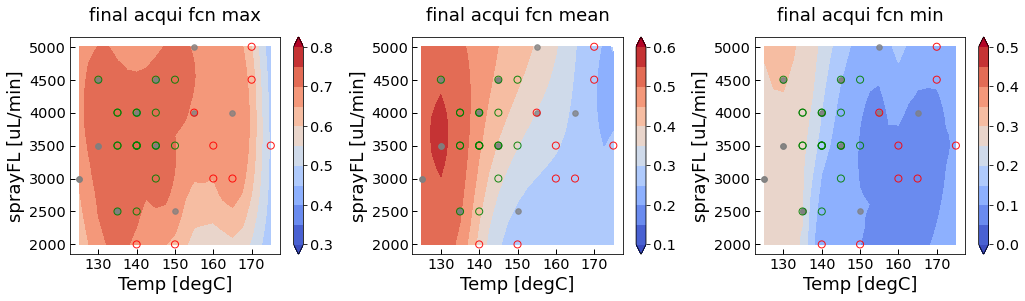

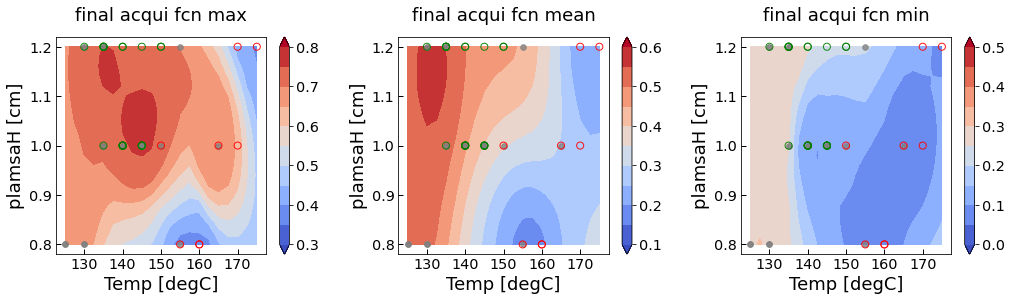

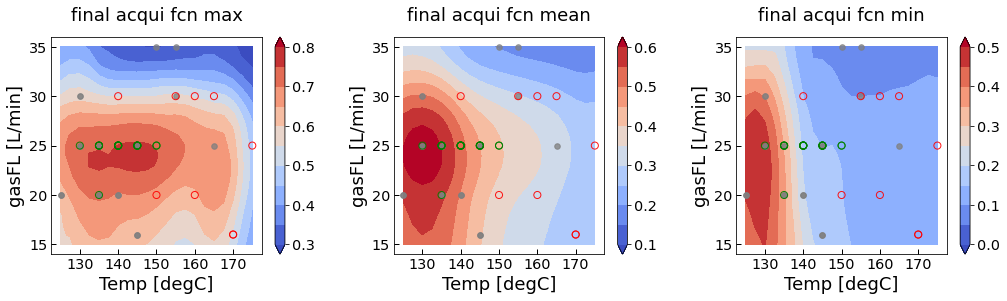

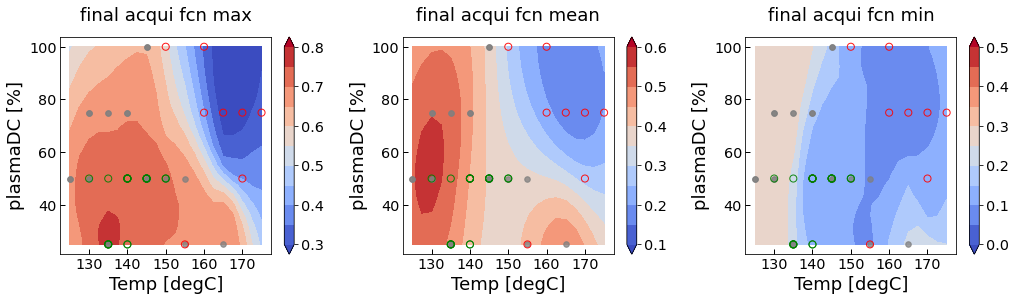

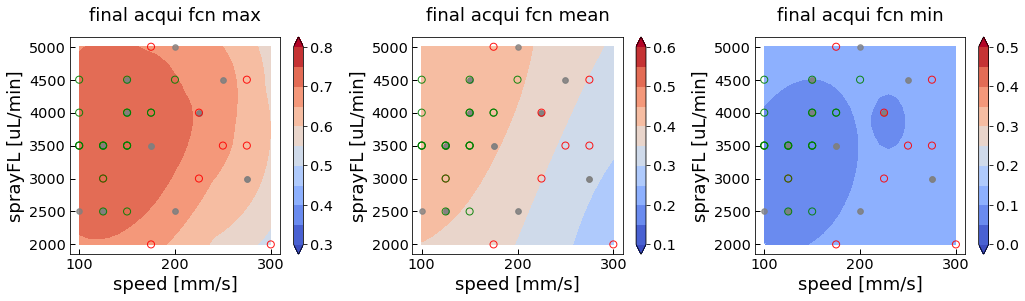

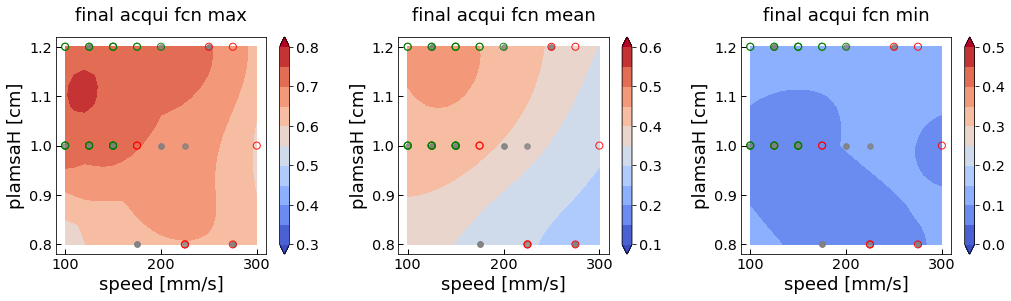

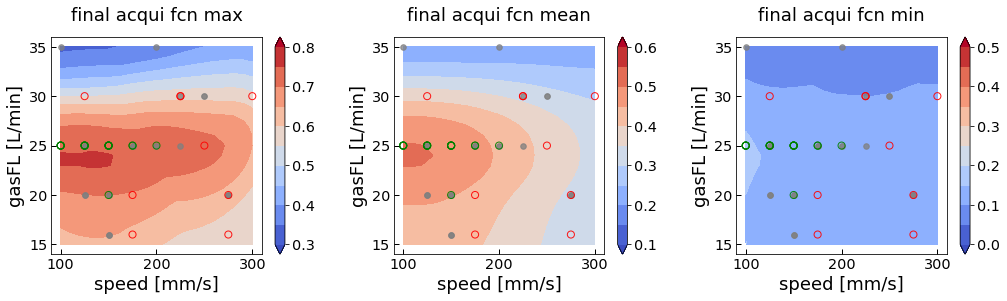

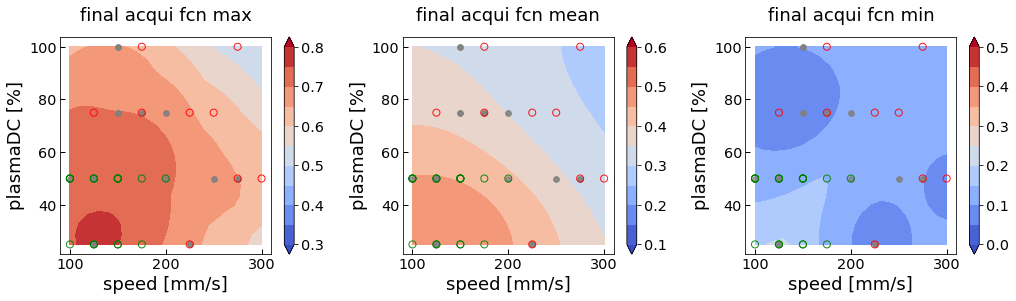

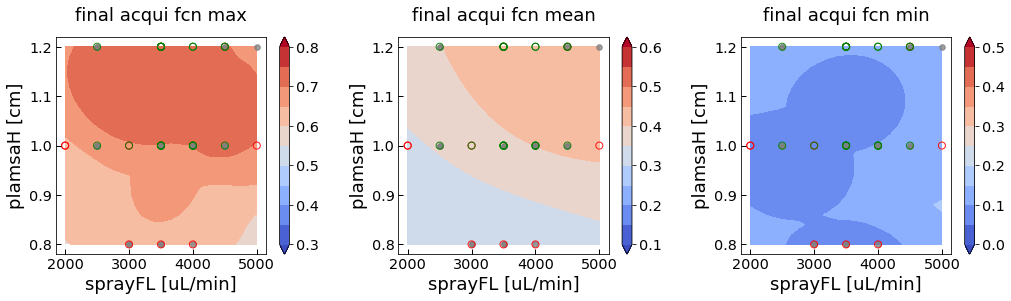

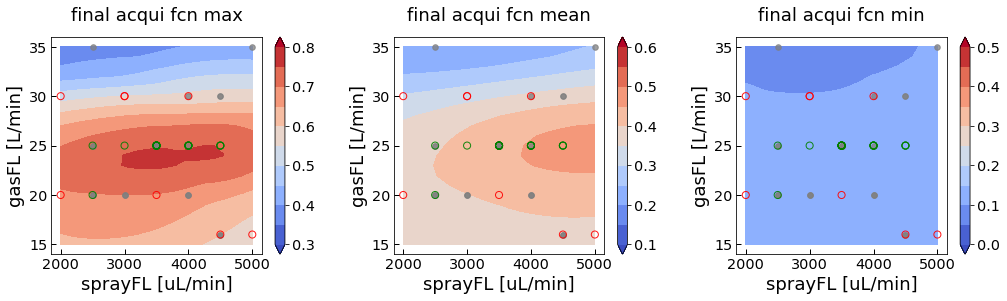

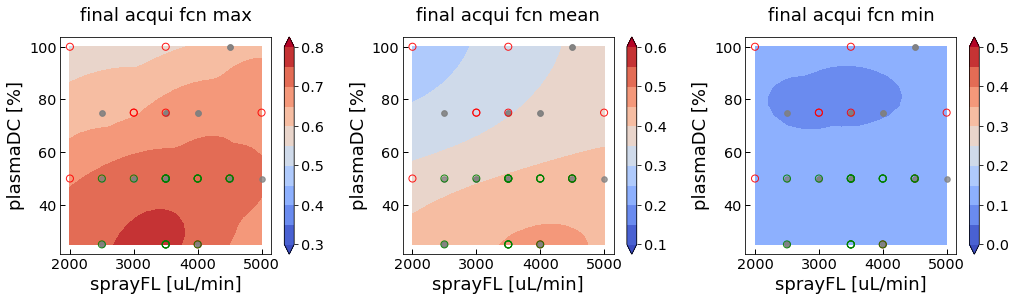

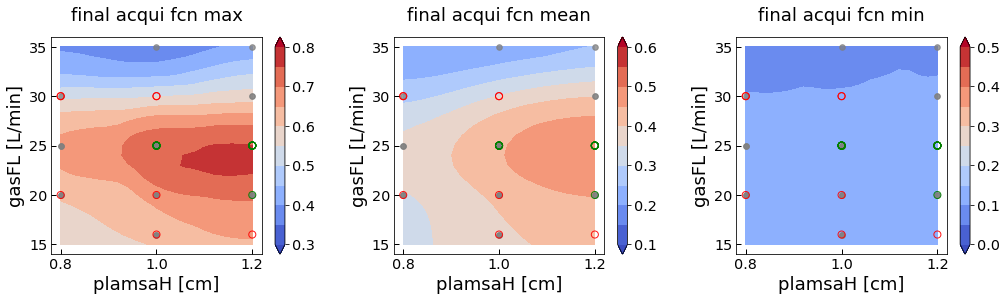

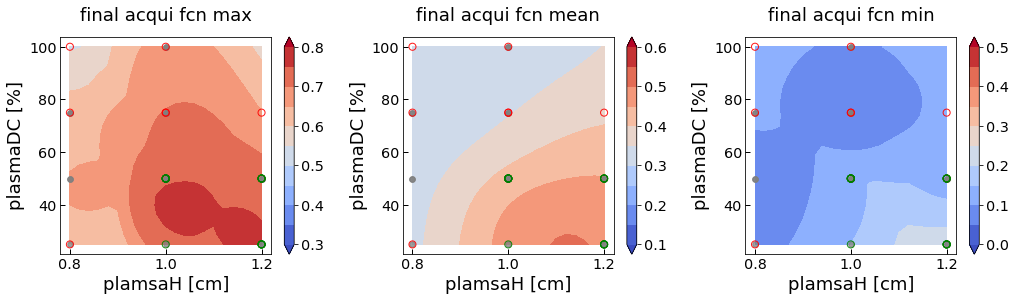

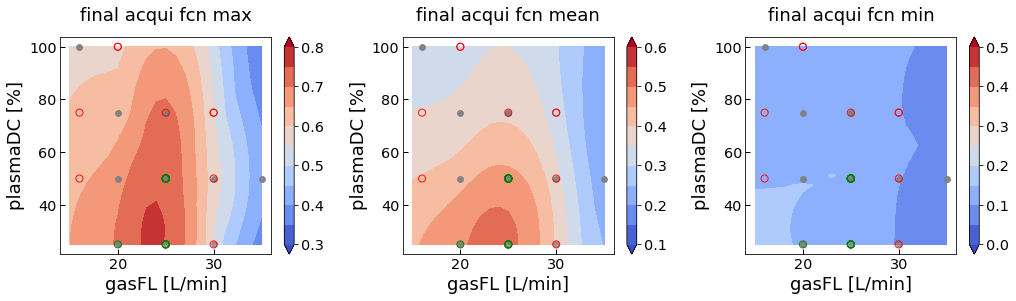

In [19]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_cons_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.3, 0.1, 0.0]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/20, levels = np.arange(11)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:
                ax.set_xticks([130, 140, 150, 160, 170])
            #ax.grid(True, linestyle='-.')
            
            
        axes[0].set_title('final acqui fcn max', pad = title_pad,fontsize = fs)
        axes[1].set_title('final acqui fcn mean', pad = title_pad,fontsize = fs)
        axes[2].set_title('final acqui fcn min', pad = title_pad,fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

##### Original Acquisition Function (based on Objective Function only)

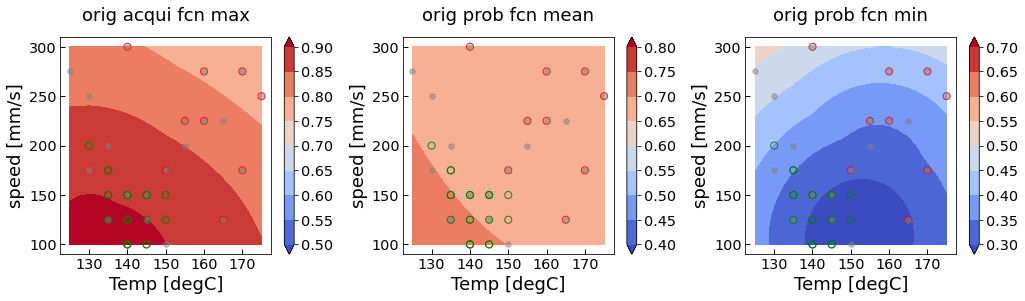

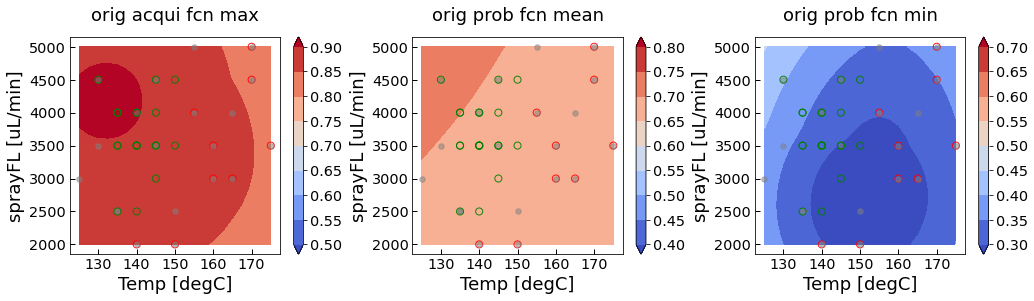

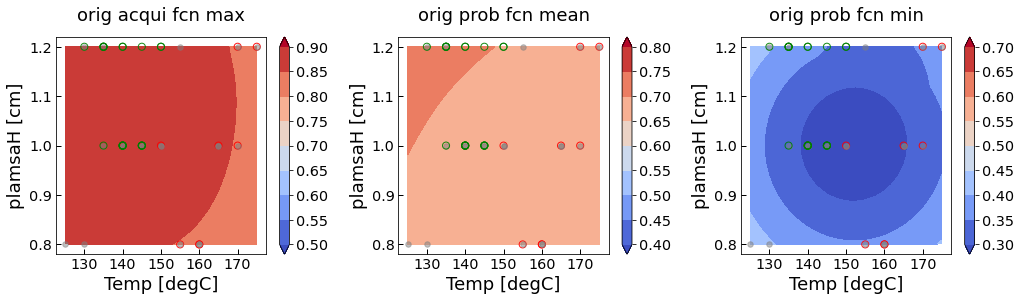

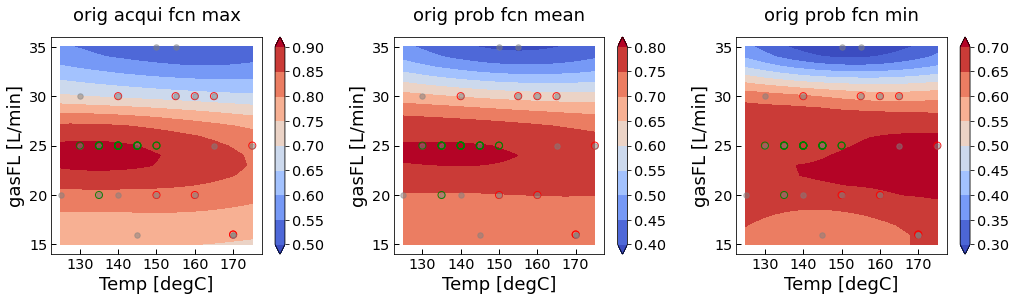

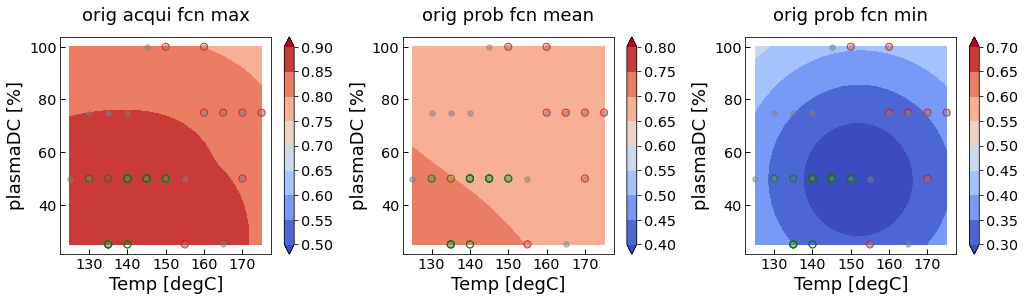

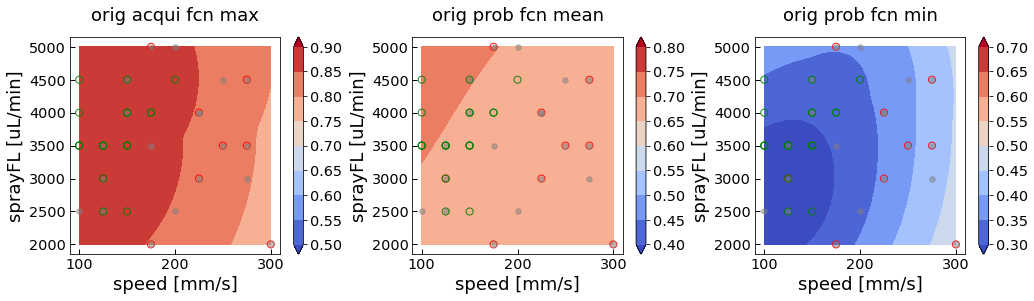

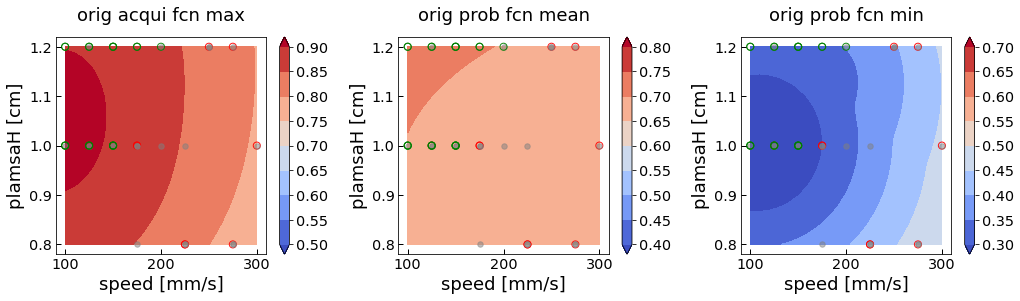

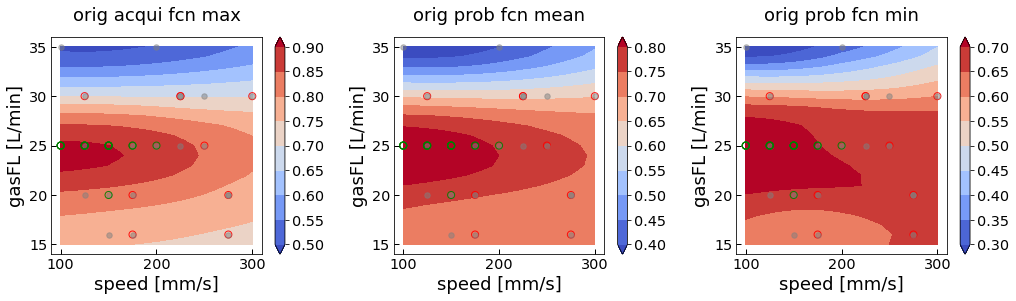

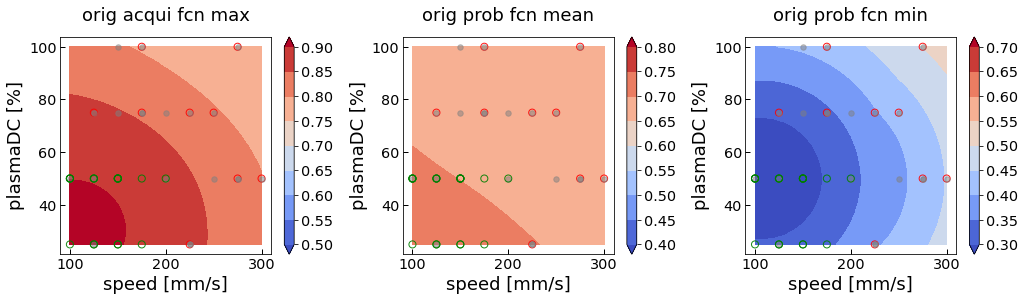

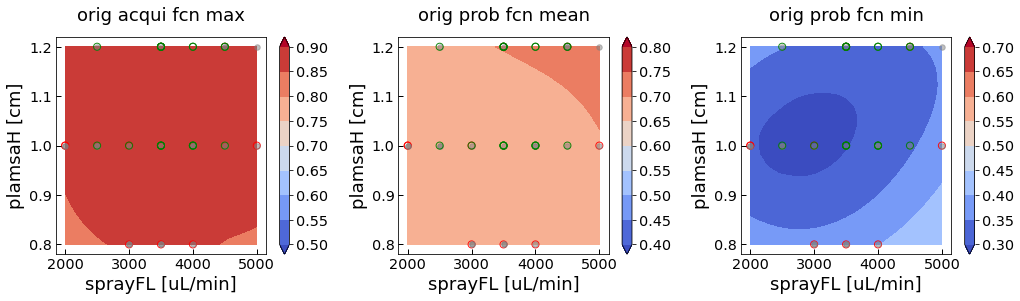

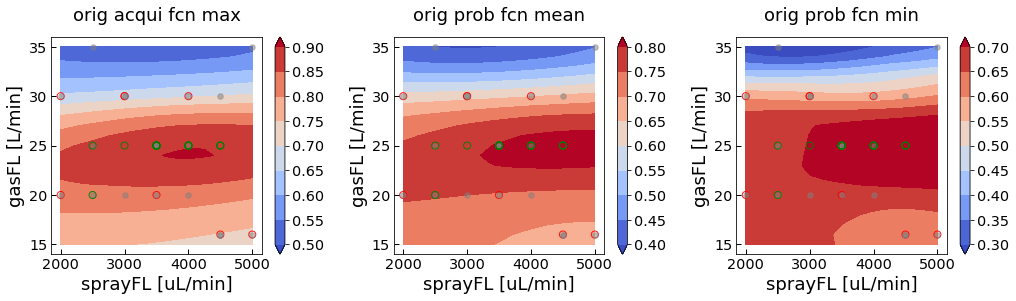

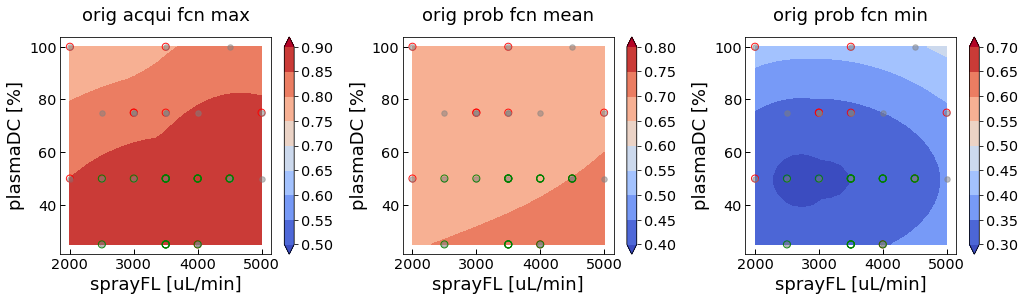

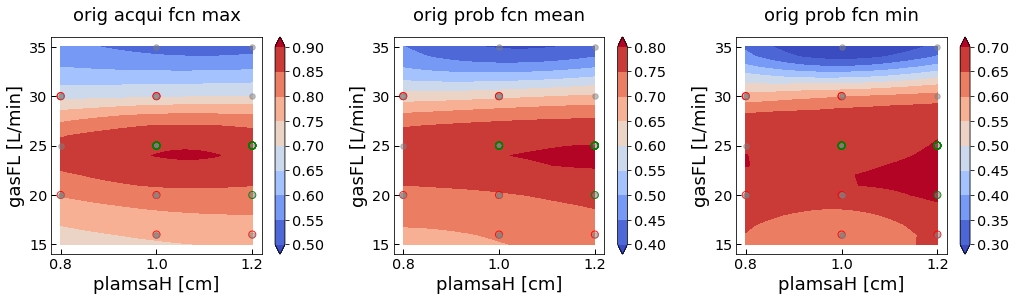

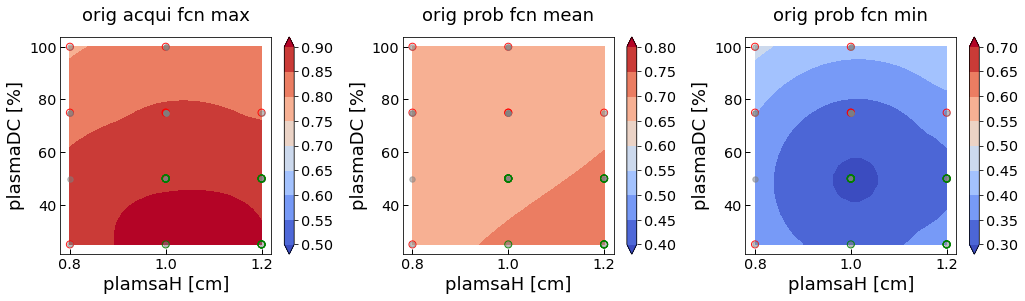

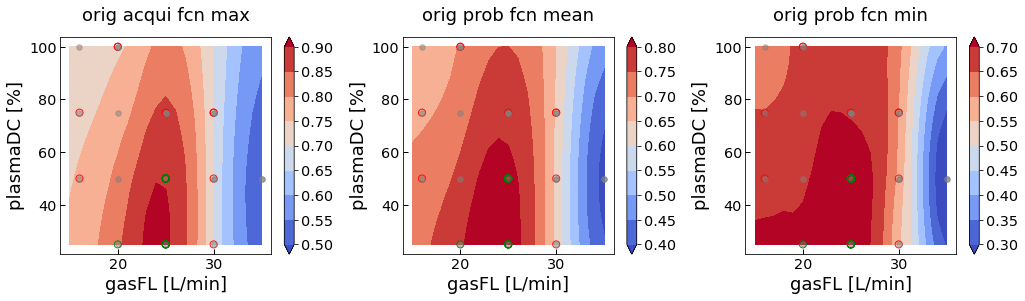

In [23]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_raw_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/20,levels = np.arange(9)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                   x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                   s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter(x_denormalizer(Xc)[:, ind1], 
                       x_denormalizer(Xc)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')

            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:
                ax.set_xticks([130, 140, 150, 160, 170])
            #axes[i].grid(True, linestyle='-.')

        axes[0].set_title('orig acqui fcn max', pad = title_pad, fontsize = fs)
        axes[1].set_title('orig prob fcn mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('orig prob fcn min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

##### Probability Function of the Constraint

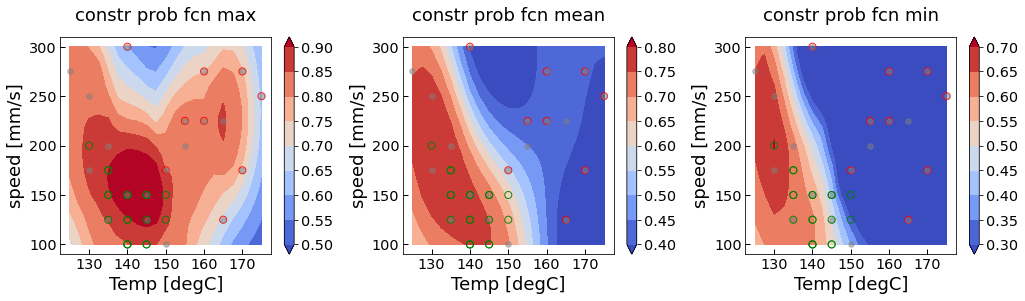

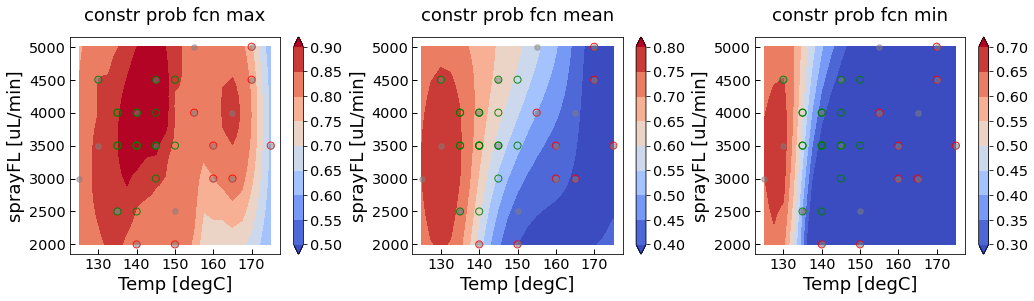

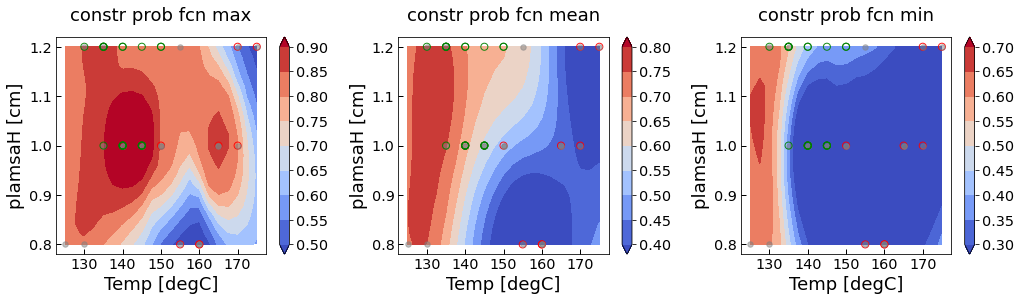

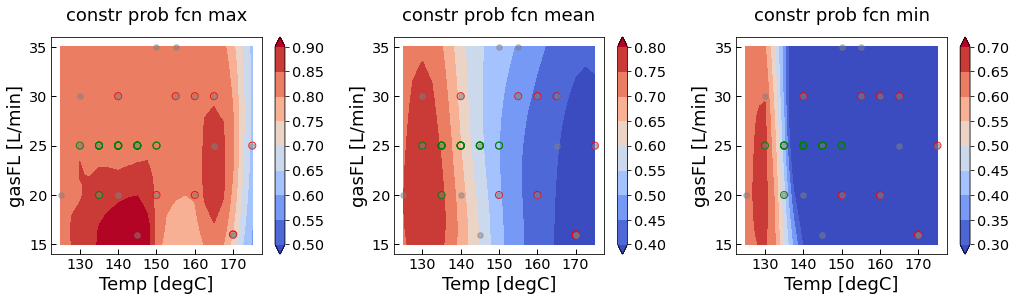

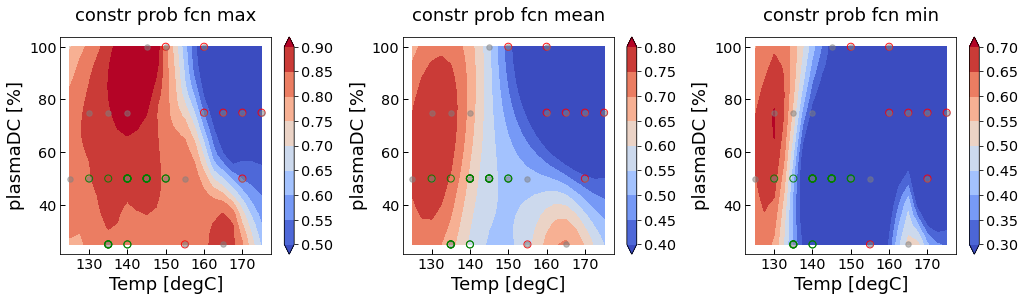

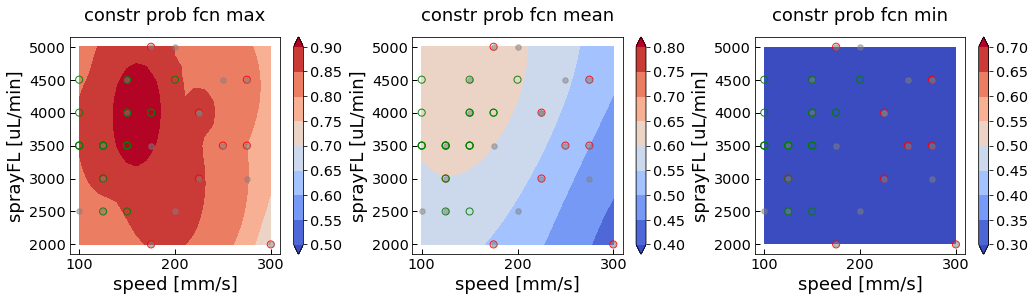

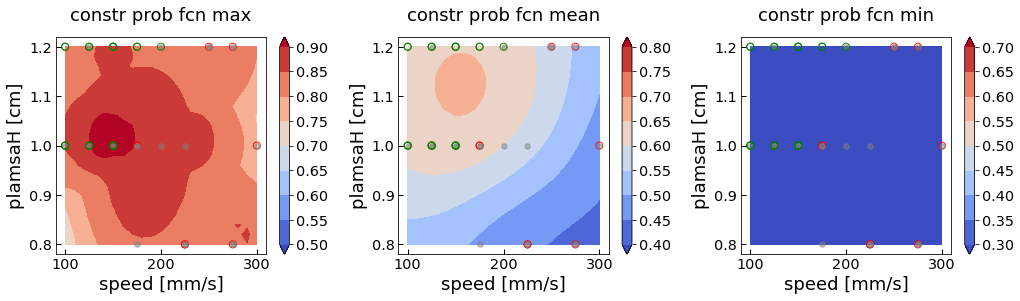

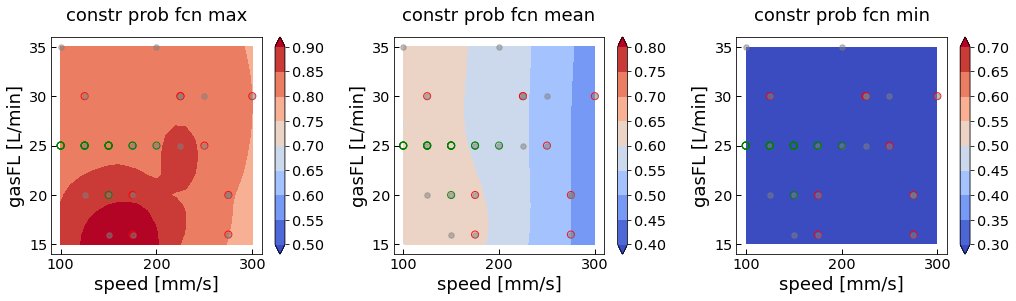

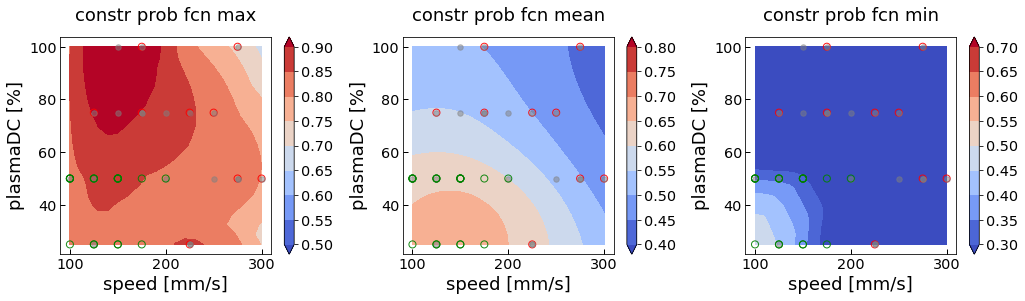

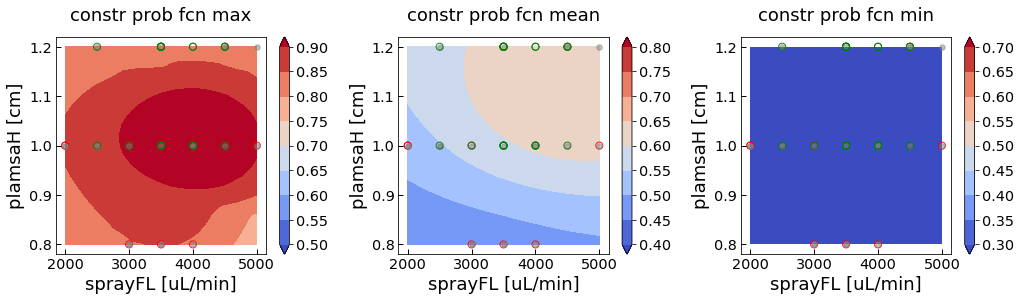

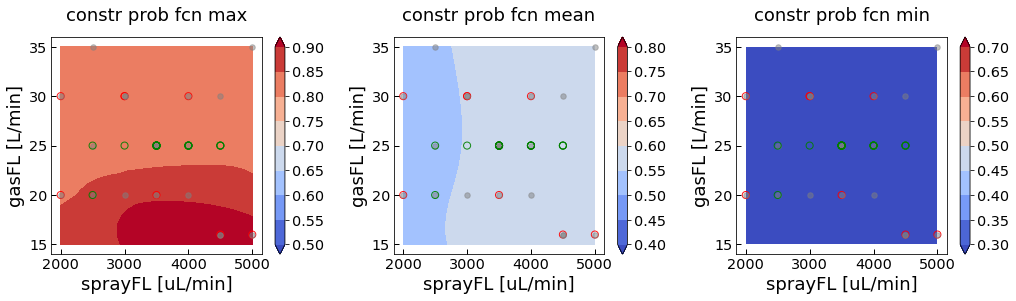

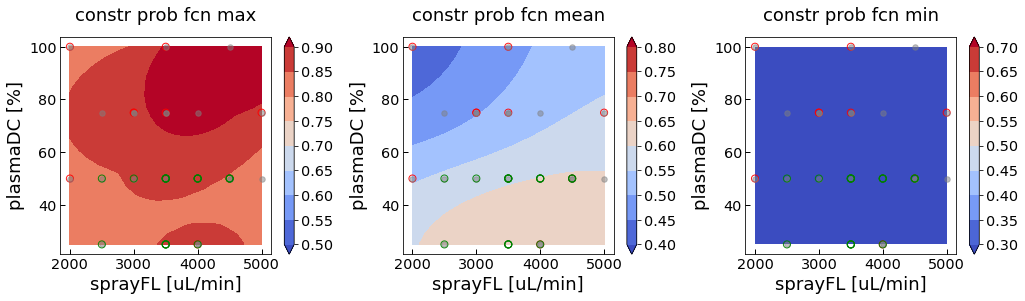

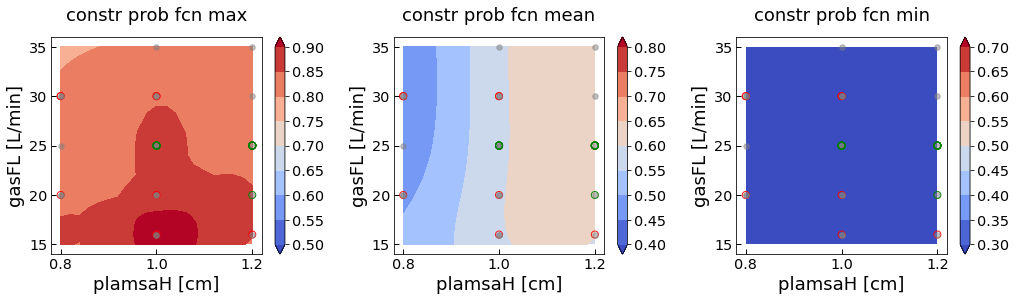

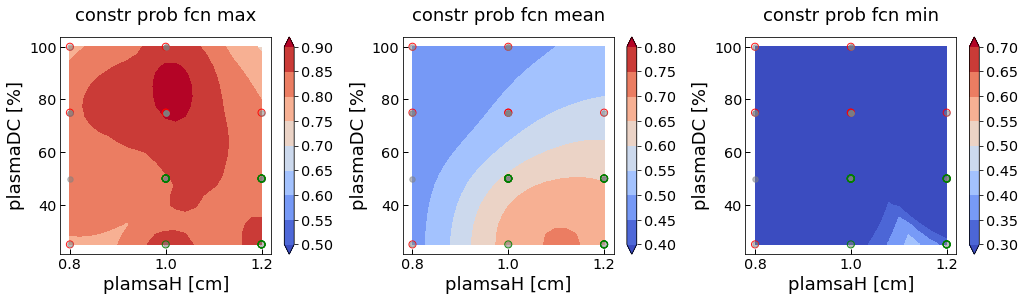

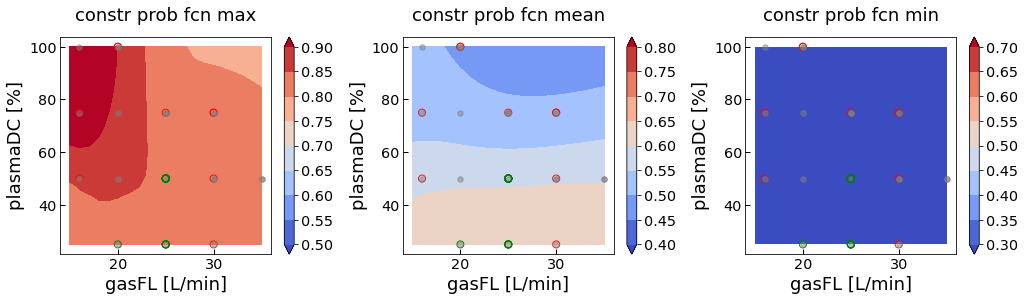

In [21]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_cons_pr(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y,levels = np.arange(9)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                   x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                   s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter(x_denormalizer(Xc)[:, ind1], 
                       x_denormalizer(Xc)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')

            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:
                ax.set_xticks([130, 140, 150, 160, 170])
            #axes[i].grid(True, linestyle='-.')

        axes[0].set_title('constr prob fcn max', pad = title_pad, fontsize = fs)
        axes[1].set_title('constr prob fcn mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('constr prob fcn min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()